# Flume

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Roe solver

In [2]:
g = 9.81
def roe2(hl,hul,hr,hur):
    """
        otra version del solver de roe
    """
    if hl<0 or hr<0:
        print 'NEGATIVE DEPTH :('
    ul = 0.0
    if hl>0: ul = hul/hl
    
    ur = 0.0
    if hr>0: ur = hur/hr
        
    #averaged state
    uhat = 0.5*(ul+hr)
    chat = 0.5*(np.sqrt(g*hl)+np.sqrt(g*hr))
    
    #averaged eigenvalues
    #notice l1 <= l3
    lhat_1 = uhat - chat
    lhat_3 = uhat + chat
    
    #interface state
    us = ul
    hs = hl
    if lhat_1>0:
        us = ul
        hs = hl
    elif lhat_3 <0:
        us = ur
        hs = hr
    else:
        cs = chat- 0.25*(ur-ul)
        hs = cs*cs/g
        us = uhat - (np.sqrt(g*hr)-np.sqrt(g*hl))
        
    return hs,us    

In [3]:
g = 9.81
def roe(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print hl,hr
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    print hs,us
    return hs,us

# Muscl Reconstruction

In [4]:
def minmod(slope1, slope2):
    if (slope1>0 and slope2 > 0):
        return min(slope1,slope2)
    if (slope1<0 and slope2<0):
        return max(slope1,slope2)
    return 0.

minmod = np.vectorize(minmod)

The $\verb;np.vectorize;$ helps to evaluate the minmod function several times along an array of data.

Now do the MUSCL reconstruction

In [5]:
def musclrecontr(q0,q1,q2,dx=1):
    """
        Receives states q=(h,hu) from a cell (call it 1) 
        and its first neighbors (0 and 2) 
        and returns muscl reconstruction q_{il} and q_{ir} of 
        conserved variables and bathymetry at  cell boundaries
        
        dx is irrelevant for regular grids
        but is kept for code semantic and mantainability        
    """
    
    #conserved variables u
    slope1 = (q1-q0)/dx
    slope2 = (q2-q1)/dx
#     slope = map(minmod,slope1,slope2)
    slope = minmod(slope1,slope2)
    qil = q1-0.5*dx*slope
    qir = q1+0.5*dx*slope
    
    return qil, qir

In [6]:
def getMusclReconstr(h,hu):
    """
    Receives 1d arrays h,hu (1xNx+4)
    and returns hl,hr, hul,hur (1\times nx+2)
    """
    nx = h.shape[0]-4
    hl = np.zeros((nx+2,))
    hr = np.zeros((nx+2,))
    hul = np.zeros((nx+2,))
    hur = np.zeros((nx+2,))
    for i in range(1,nx+3,1):
        q0 = np.array([h[i-1],hu[i-1]])
        q1 = np.array([h[i],hu[i]])
        q2 = np.array([h[i+1],hu[i+1]])
        (hl[i-1],hul[i-1]), (hr[i-1],hur[i-1]) = musclrecontr(q0,q1,q2)
    return hl, hr, hul, hur  

## Verification of MUSCL reconstruction

The idea is to see the MUSCL interpolations. What has to be verified is that at each cell the slopes follow the minmod rule.

### Simple test with one cell only

Simple test: 

    h = [0,1,0]
    hu = [1,2,5]

Should result in

    [h1l,h1r] = [1,1] (opposite sign slopes)
    [hu1l, hu1r] = [1.5, 2.5] (lowest slope = 1.0)

In [7]:
u0 = np.array([0.,1.])
u1 = np.array([1.,2.])
u2 = np.array([0.,5.])
(hl,hul), (hr,hur) = musclrecontr(u0,u1,u2)
print 'h1l, h1r = ',hl,hr
print 'hu1l, hu1r = ',hul, hur

h1l, h1r =  1.0 1.0
hu1l, hu1r =  1.5 2.5


### Test an array

The arrays to be tested

In [8]:
nx = 5 
x = np.linspace(0,5,6)
h = 10-(x-2)**2
hu = np.linspace(0,0.5,6)**2

Plot them to see what to expect. Notice that I am plotting the cell-centered values with the help of the step function

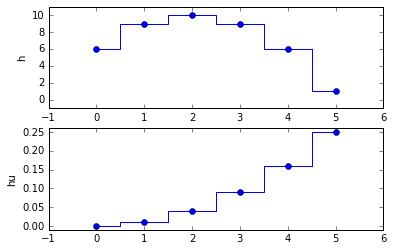

In [9]:
plt.subplot(211)
plt.step(x,h,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,11)
plt.ylabel('h')

plt.subplot(212)
plt.step(x,hu,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-0.01,0.26)
plt.ylabel('hu')

In [10]:
hl, hr, hul, hur   = getMusclReconstr(h,hu)

This function is for plotting 

In [11]:
def check_muscl(x,h,hl,hr,ylim=0):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.step(x,h,'ko',where='mid')
    for i in range(hl.shape[0]):
        s1 = h[i+1]-h[i]
        s2 = h[i+2]-h[i+1]   
        l1 = plt.plot([x[i+1]-0.5,x[i+1]+0.5],[h[i+1]-0.5*s1,h[i+1]+0.5*s1],'g')
        l2 = plt.plot([x[i+1]-0.5,x[i+1]+0.5],[h[i+1]-0.5*s2,h[i+1]+0.5*s2],'b')
#     plt.xlim(-1,6)
    if ylim!=0:
        plt.ylim(ylim)
    plt.title('s1,s2')

    plt.subplot(122)
    plt.step(x,h,'ko',where='mid')
    for i in range(hl.shape[0]):
        s1 = h[i+1]-h[i]
        s2 = h[i+2]-h[i+1]
        plt.plot([x[i+1]-0.5,x[i+1]+0.5],[hl[i],hr[i]],'r')
    if ylim!=0:
        plt.ylim(ylim)
    plt.title('minmod(s1,s2)')
    plt.legend(loc=0)
    # plt.ylim(-0.1,1.1)

The figure to the left shows the original step function along with the two possible interpolators (in green and blue). The figure to the right shows in red the chosen interpolator that should be following the minmod rule.

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


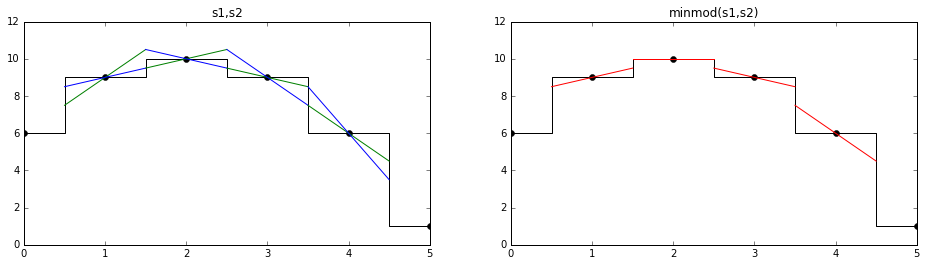

In [12]:
check_muscl(x,h,hl,hr,ylim=[0,12])
plt.ylim(0,12);

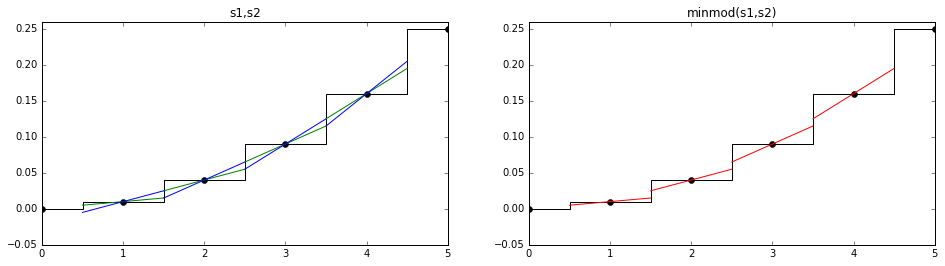

In [13]:
check_muscl(x,hu,hul,hur,ylim=[-0.05,0.26])

# Flux function

In [14]:
def flux(h,u):
    """
        Receives scalars h,u
        Returns array F(u) of size 2
    """
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

### Prototype of one iteration

In [15]:
def setdt(h,hu,n,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))
    dt = cfl*dx/np.max(s)
    return dt

#### Initial condition

(-1, 2)

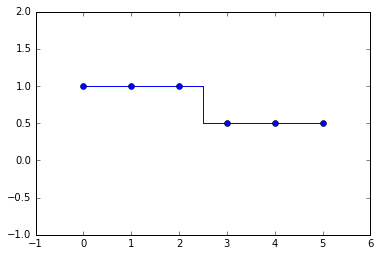

In [16]:
nx = 2
nt = 2
x = np.linspace(0,5,nx+4)
dx = np.diff(x)[0]

h = np.zeros((nt,nx+4))
hu = np.zeros((nt,nx+4))
h[0,:] = np.where(x<=2, 1.0, 0.5)

cfl = 0.4
dt = setdt(h,hu,0,dx,cfl)

plt.step(x,h[0,:],'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)


#### Reconstruct interface vecinity values 

In [17]:
hl, hr, hul, hur   = getMusclReconstr(h[0,:],hu[0,:]);
fs = np.zeros((2,nx+1))
fs.shape

(2, 3)

#### Calculate the fluxes in the interfaces

In [18]:
for i in range(nx+1):        
    hs,us = roe(hr[i],hur[i],hl[i+1],hl[i+1])
    fs[:,i] = flux(hs,us) 

0.846733335746 0.5
0.598665128317 1.41736849364
0.393490139703 0.5


In [19]:
fs

array([[ 0.42336667,  0.84852909,  0.19674507],
       [ 3.7283591 ,  2.96063009,  0.85783571]])

#### Step one iteration

In [20]:
n = 0
h[n+1,2:-2] = h[n,2:-2] -dt/dx*(fs[0,1:] - fs[0,:-1])
hu[n+1,2:-2] = hu[n,2:-2] -dt/dx*(fs[1,1:] - fs[1,:-1])

#### Results

In [21]:
print h

[[ 1.          1.          1.          0.5         0.5         0.5       ]
 [ 0.          0.          0.94570243  0.58323945  0.          0.        ]]


In [22]:
print hu

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.0980468   0.26854823  0.          0.        ]]


### Generic functions from this example

In [23]:
def fluxes(h,hu,n):
    """
        Calcula loos flujos en cada interfaz,
        retorna la matriz de 2xninterfaces
    """
    nx = h.shape[1]-4
    hl, hr, hul, hur   = getMusclReconstr(h[n,:],hu[n,:])
    fs = np.zeros((2,nx+1))
    for i in range(nx+1):
        hs,us = roe(hr[i],hur[i],hl[i+1],hul[i+1])
        fs[:,i] = flux(hs,us)
    return fs

In [24]:
def bcs_closed(h,hu,n):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    hb = 1.*h
    hub = 1.*hu
    hb[n,0] = h[n,2]
    hb[n,1] = h[n,2]
    hub[n,0] = -hu[n,2]
    hub[n,1] = -hu[n,2]
    
    hb[n,-1] = h[n,-3]
    hb[n,-2] = h[n,-3]
    hub[n,-1] = -hu[n,-3]   
    hub[n,-2] = -hu[n,-3]    
    return hb,hub

In [25]:
def simulate(h,hu,bcs,dx,cfl,t0,nt):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        h,hu = bcs(h,hu,n)    
        
        f = fluxes(h,hu,n)

        h[n+1,2:-2] = h[n,2:-2] -dt/dx*(f[0,1:] - f[0,:-1])
        hu[n+1,2:-2] = hu[n,2:-2] -dt/dx*(f[1,1:] - f[1,:-1])
        
    return t,h,hu

### Comparison of first iteration

In [26]:
t0 = 0.0

In [27]:
h2 = 1.*h
hu2 = 1.*hu

h2[1,:] = 0.0
hu2[1,:] = 0.0

print h2
print hu2

[[ 1.   1.   1.   0.5  0.5  0.5]
 [ 0.   0.   0.   0.   0.   0. ]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


In [28]:
t,h2,hu2 = simulate(h,hu,bcs_closed,dx,cfl,t0,nt)

1.0 0.0
0.728553390593 0.917368493638
0.5 0.0


In [29]:
print h2
print hu2

[[ 1.          1.          1.          0.5         0.5         0.5       ]
 [ 0.          0.          0.91464466  0.58535534  0.          0.        ]]
[[-0.         -0.          0.          0.         -0.         -0.        ]
 [ 0.          0.          0.21561945  0.25419435  0.          0.        ]]


In [30]:
print h
print hu

[[ 1.          1.          1.          0.5         0.5         0.5       ]
 [ 0.          0.          0.94570243  0.58323945  0.          0.        ]]
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.0980468   0.26854823  0.          0.        ]]


Cool. They are the same :)

# Validation: Dambreak 1D

(0, 11)

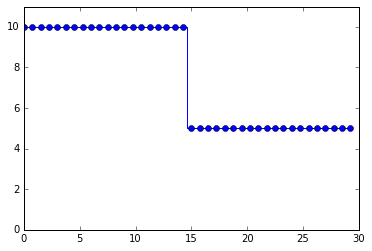

In [31]:
L = 30.
npoints = 40
dx = L/40
x = np.arange(0,L,dx)
dx = np.min(np.diff(x))
nx = x.shape[0]
cfl = 0.3
t0  = 0.
nt = 300

h = np.zeros((nt,x.shape[0]))
hu = np.zeros((nt,x.shape[0]))
h[0,:] = np.where(x<L/2, 10., 5.)
hu[0,:] = 0.

plt.step(x,h[0,:],'o',where='mid')
plt.ylim(0,11)

In [32]:
t,h,hu = simulate(h,hu,bcs_closed,dx,cfl,t0,nt)

10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
7.28553390593 2.90097389357
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
9.5999034649 0.400322454164
7.24927117754 2.5843370175
5.57786486994 0.787297699515
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
5.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
9.94381748562 0.0557245998298
9.22841750671 0.776622603034
7.27117147853 2.48457110302
5.99828323597 1.35002143977
5.06754008283 0.0942870070253
5.0 

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


9.99996469634 -6.9682073871e-06
9.99992796231 7.1224513233e-05
9.99963281011 0.000368848262971
9.99832017059 0.00166614350464
9.99325625699 0.00668085152572
9.97630023713 0.0234880054451
9.92761197028 0.0718382371847
9.80886821903 0.19033180487
9.5630698047 0.43832246148
9.1113823976 0.903844012902
8.51078771901 1.51289970645
8.06326589608 2.0465343487
7.68761114433 2.45987652653
7.3883113268 2.72860187495
7.28075518785 2.90252905276
7.28603729231 2.95365872543
7.27736638046 2.94985871974
7.25589339304 2.90328873217
7.24848076472 2.8971507675
7.26371520391 2.91465462786
7.28054736392 2.93663689184
7.27906278035 2.93951765344
7.25759244842 2.90859846101
7.24931533519 2.89901443095
7.25391024045 2.91082114716
7.27003691346 2.92678298594
7.25542598245 2.90512370322
7.03156077547 2.67184546468
5.99948929137 1.34070451837
5.18425325623 0.25596692741
5.02858157092 0.03998268833
5.00411727613 0.00576604854882
5.00057136781 0.000800300740045
5.00007548527 0.000105748953654
5.00000935601 1.3181


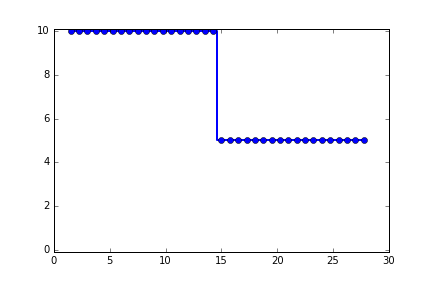
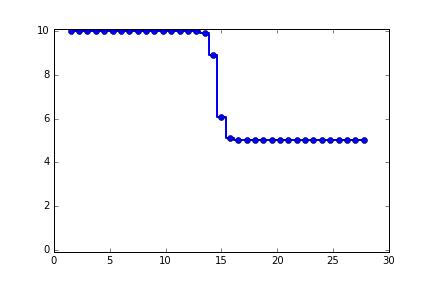
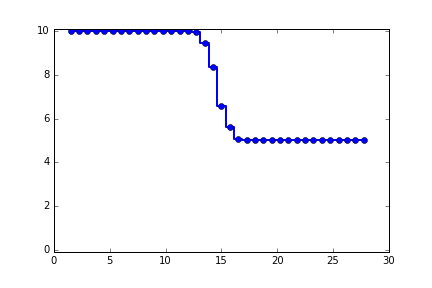
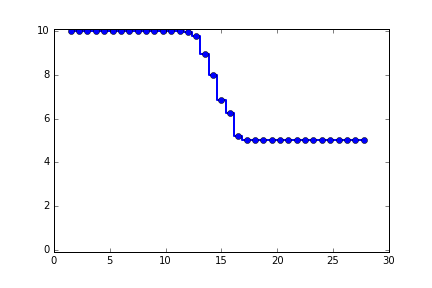
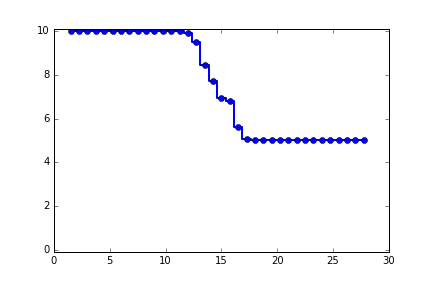
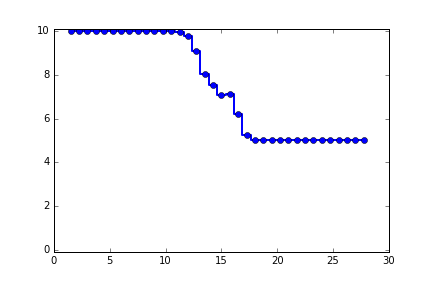
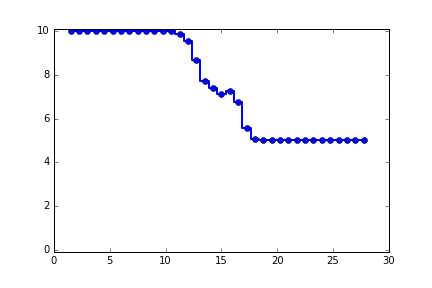
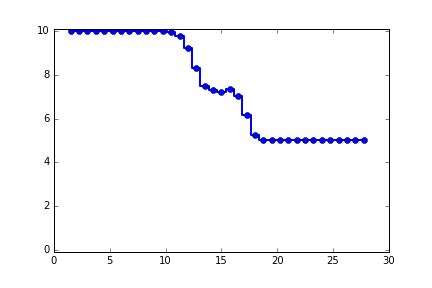
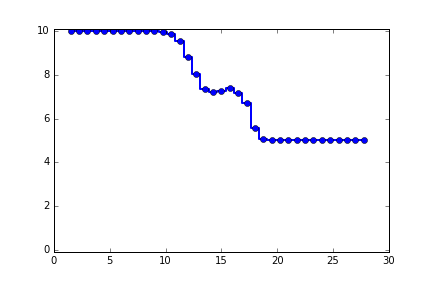
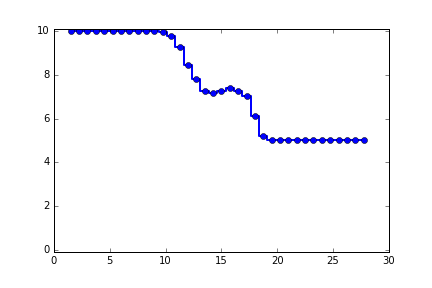
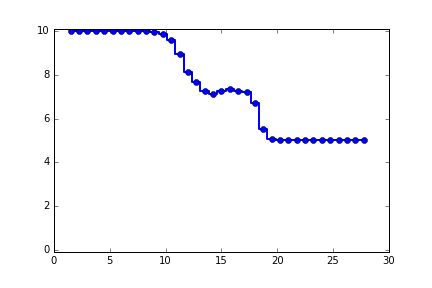
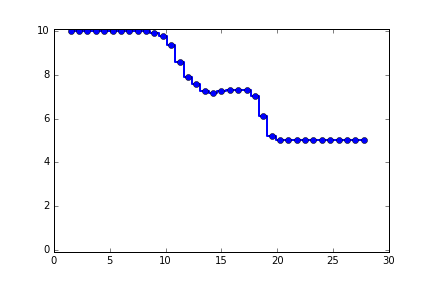
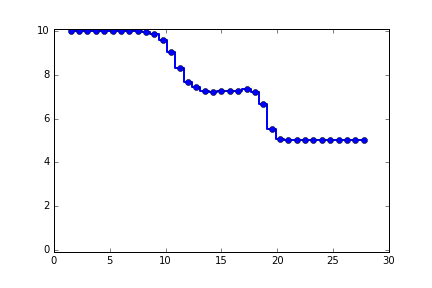
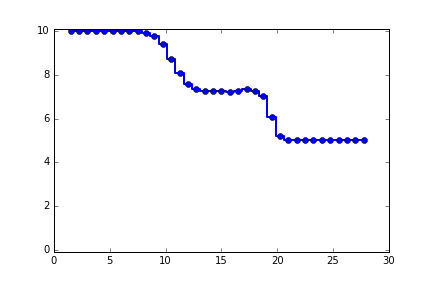
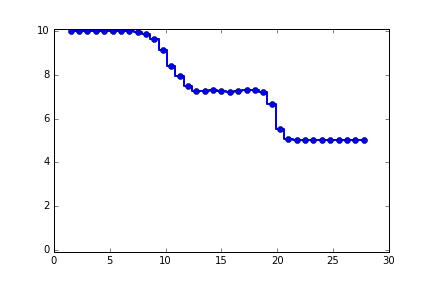
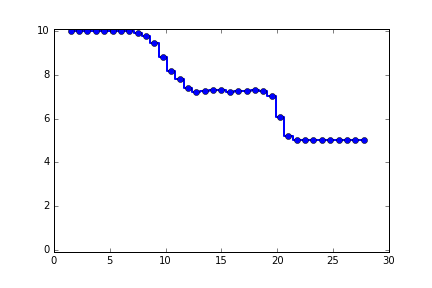
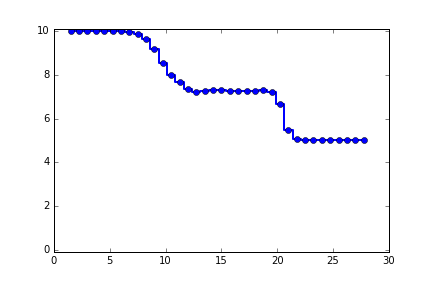
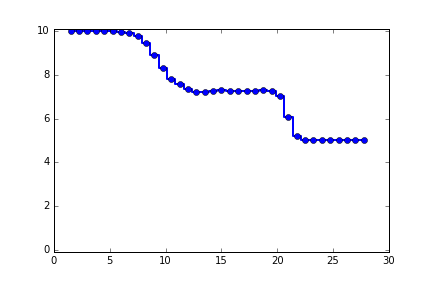
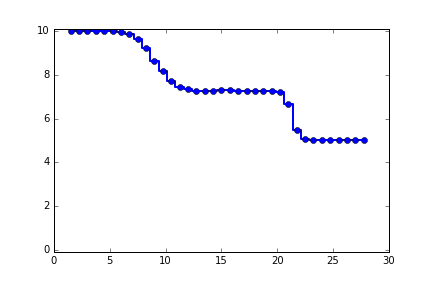
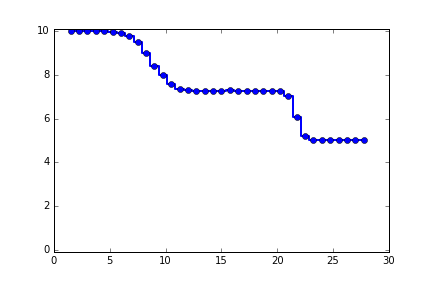
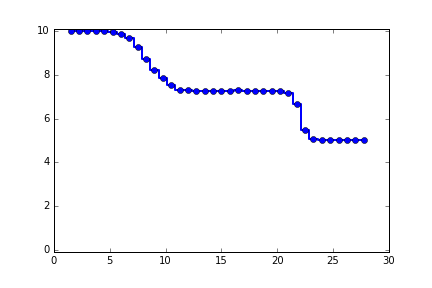
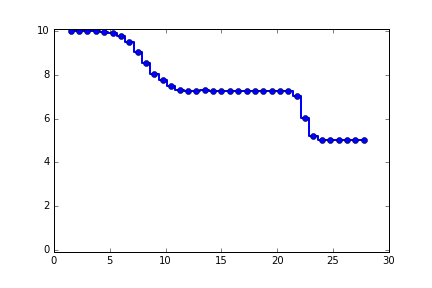
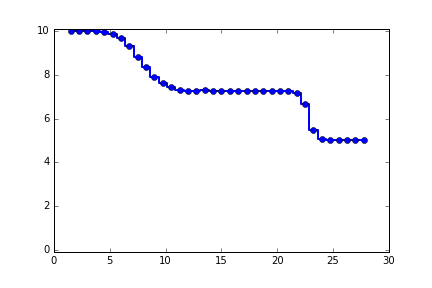
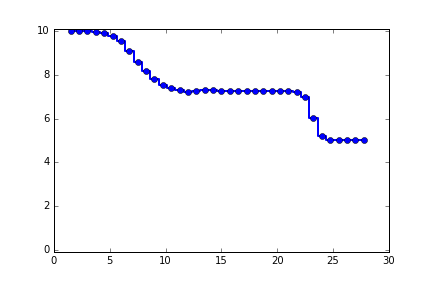
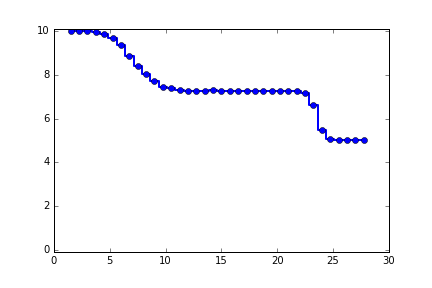
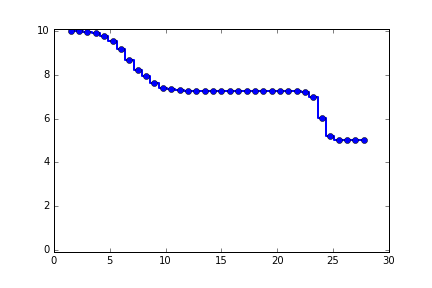
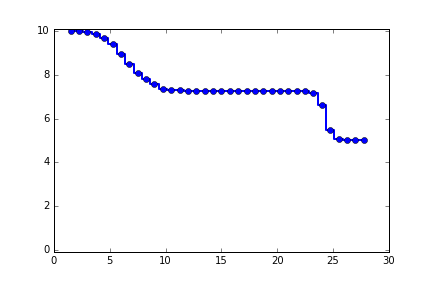
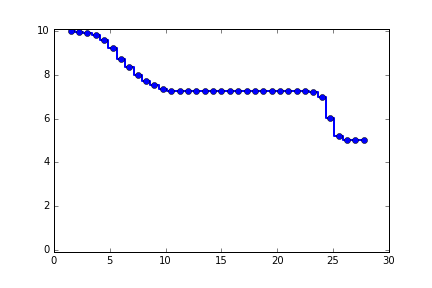
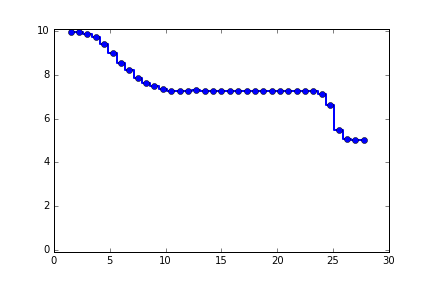
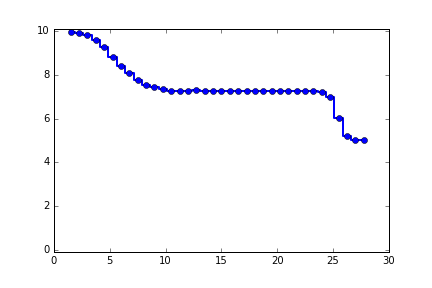
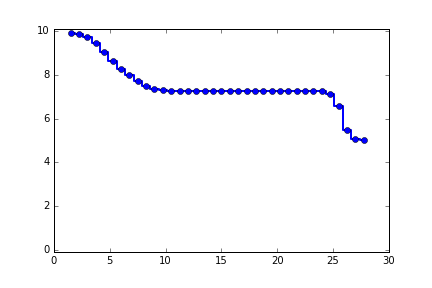
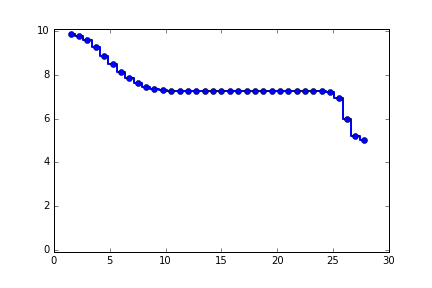
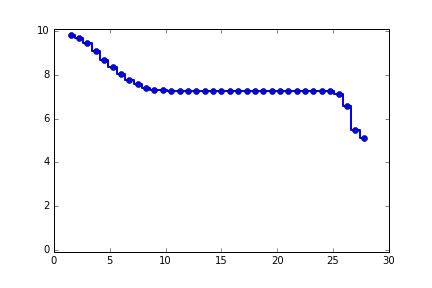
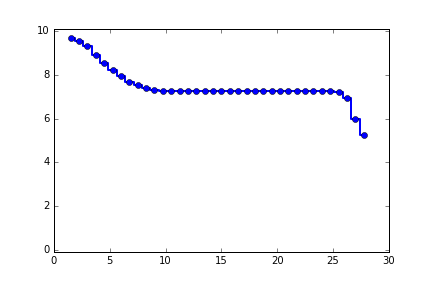
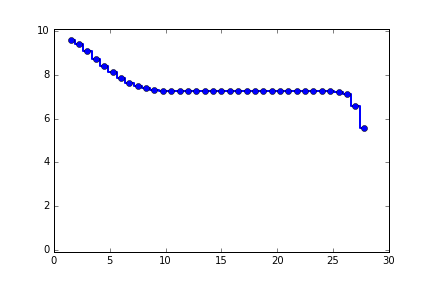
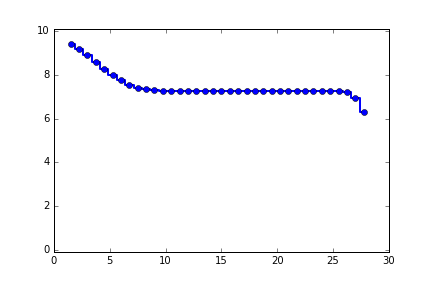
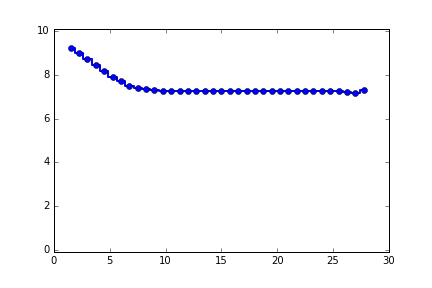
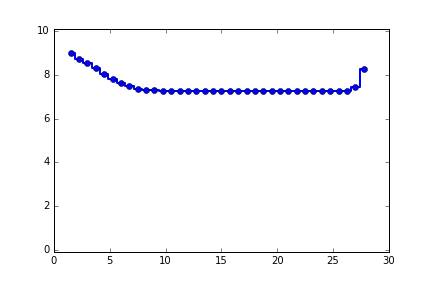
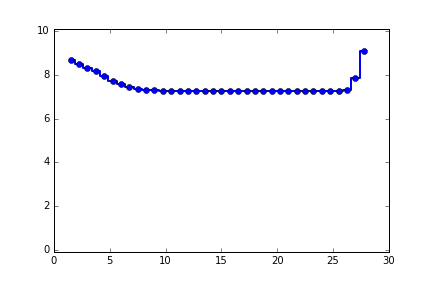
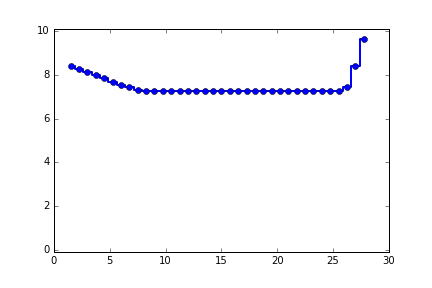
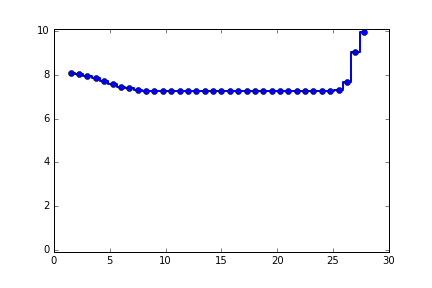
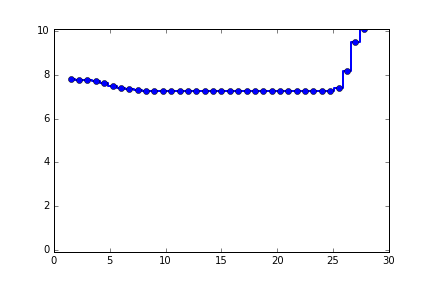
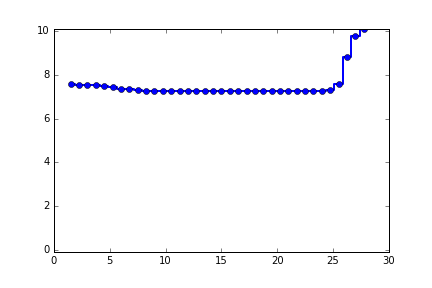
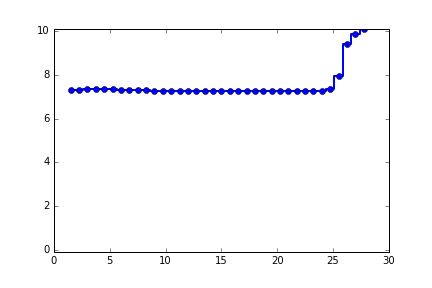
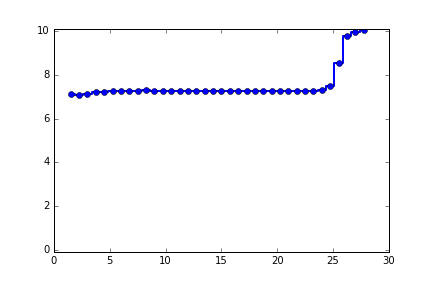
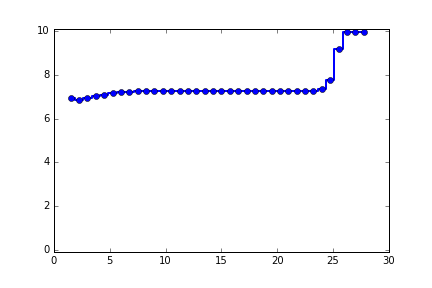
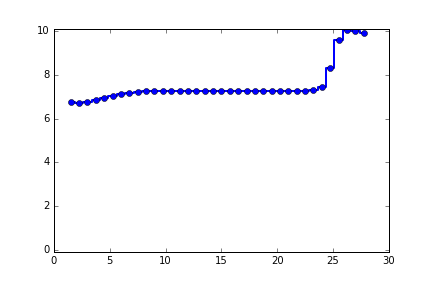
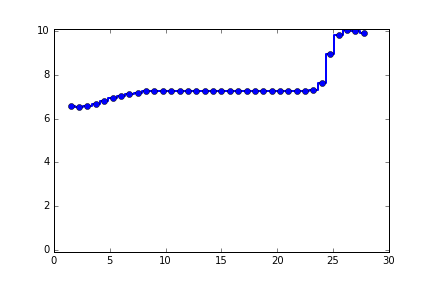
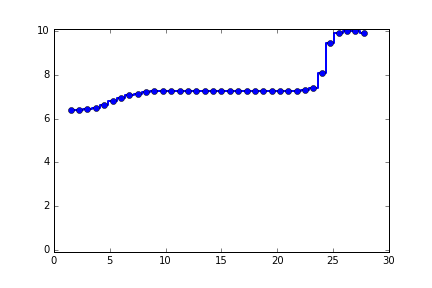
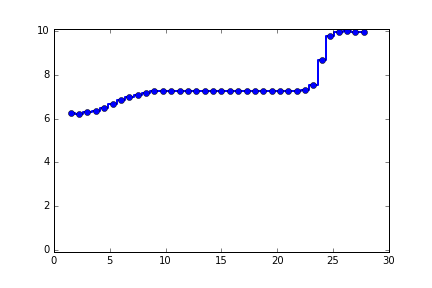
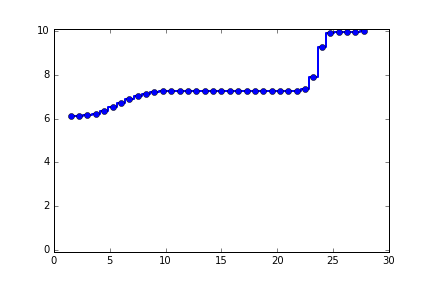
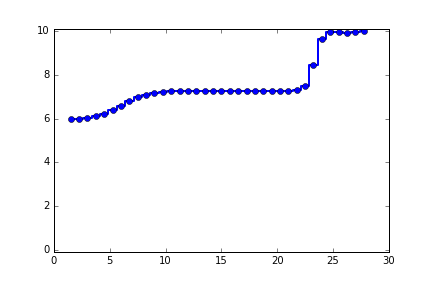
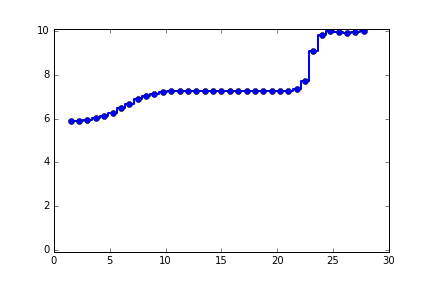
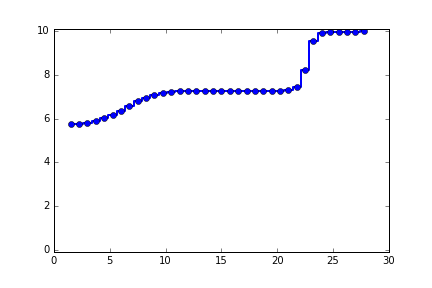
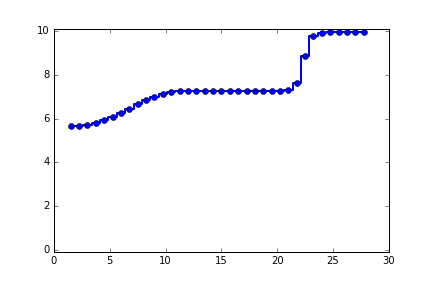
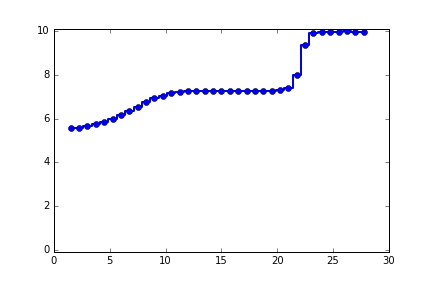
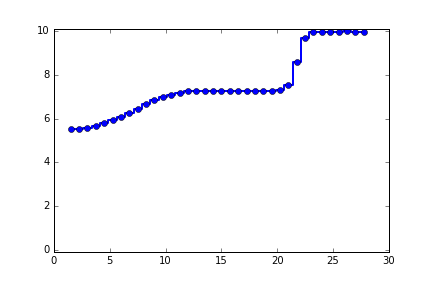
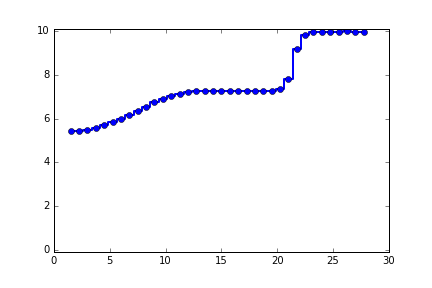
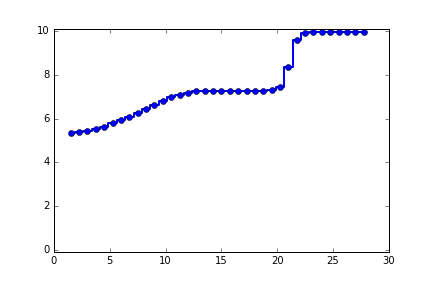
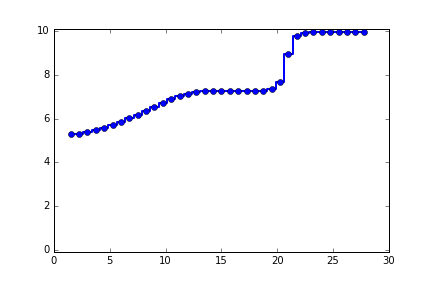
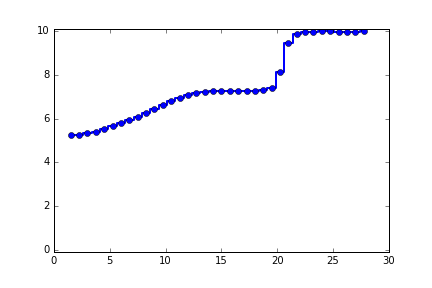
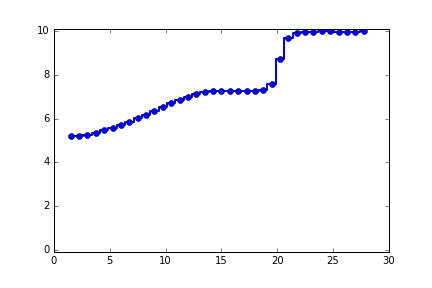
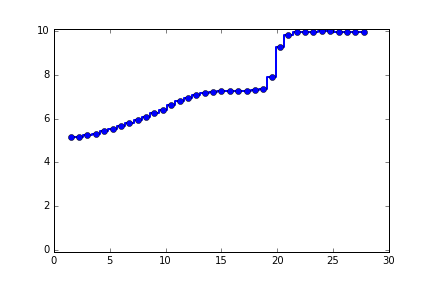
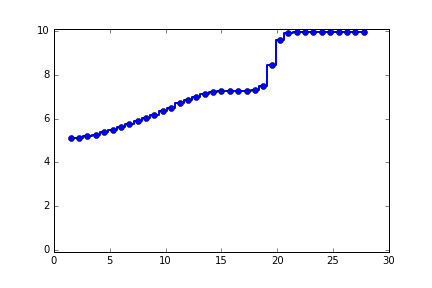
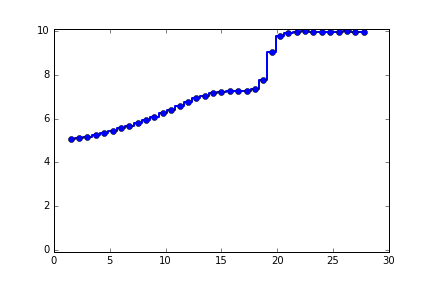
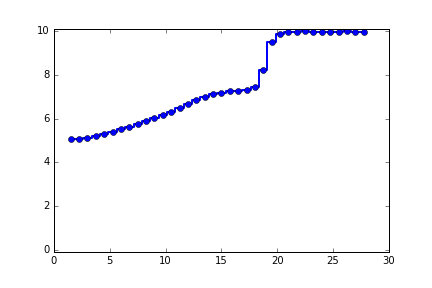
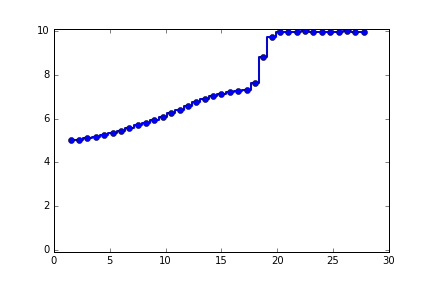
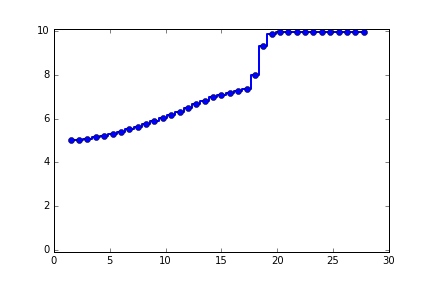
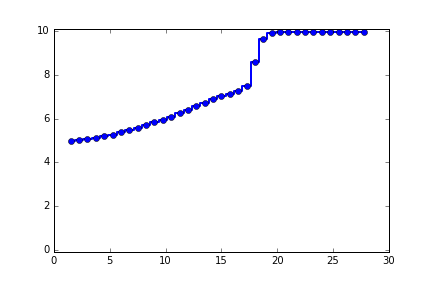
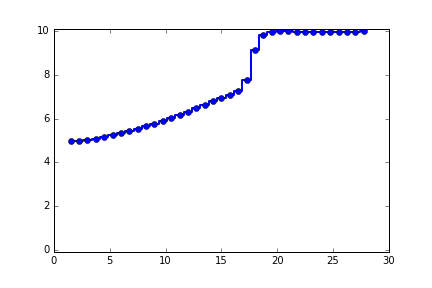
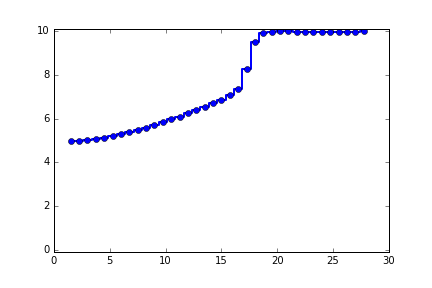
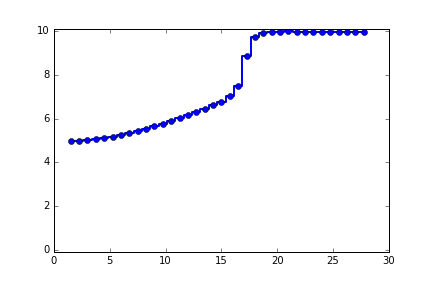
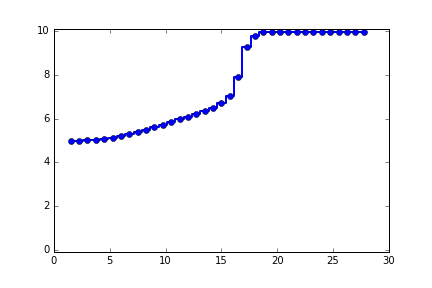
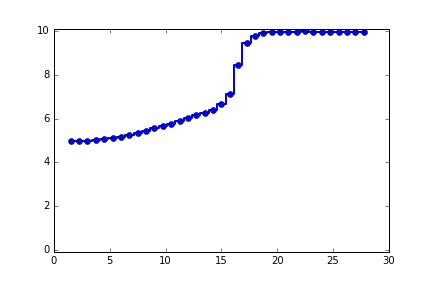
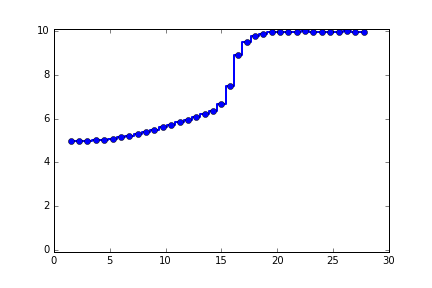
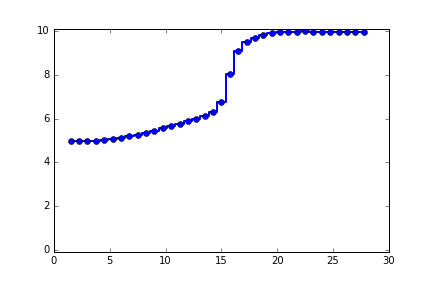
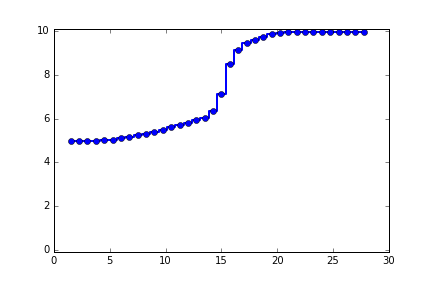
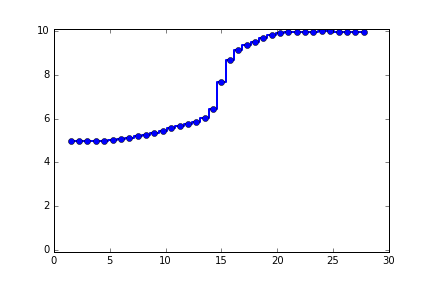
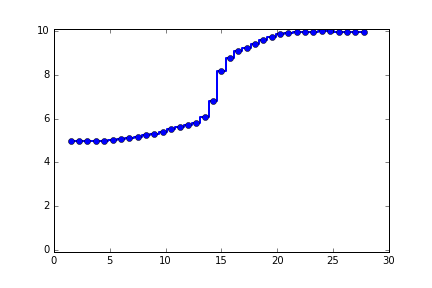
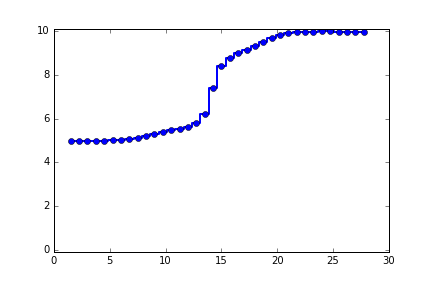
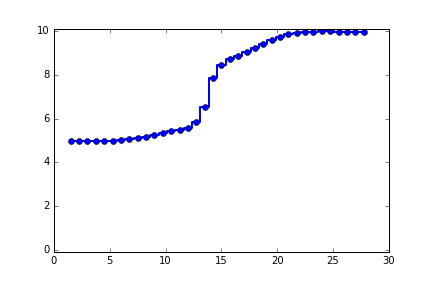
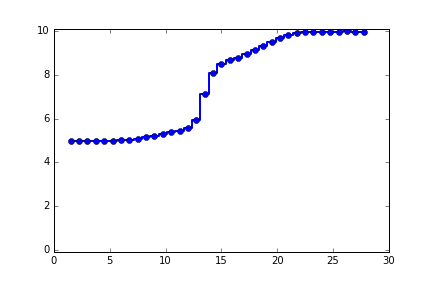
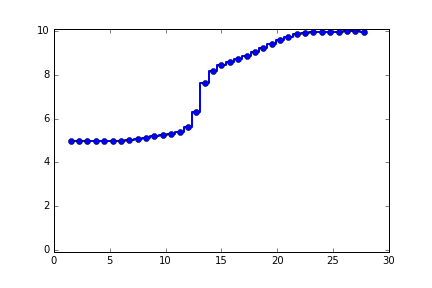
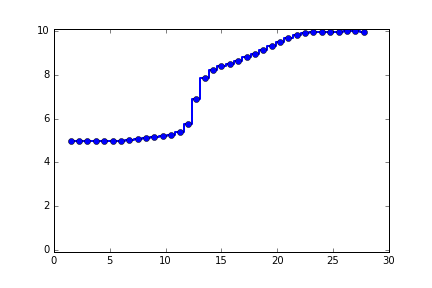
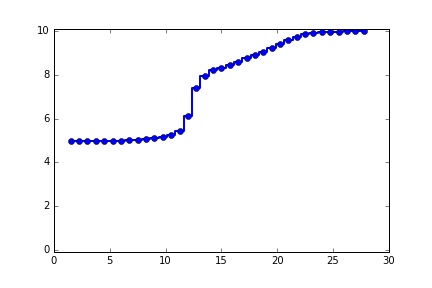
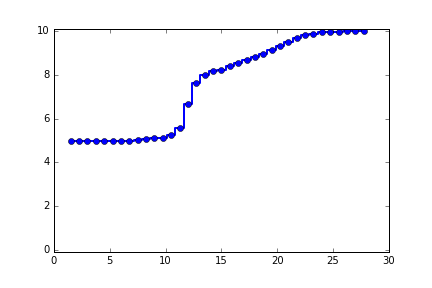
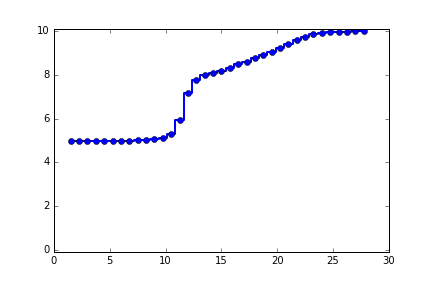
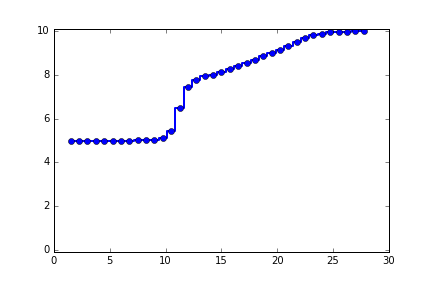
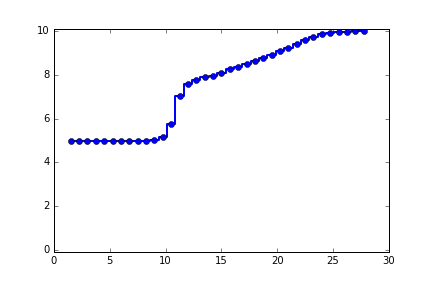
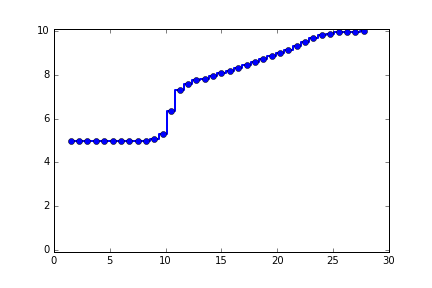
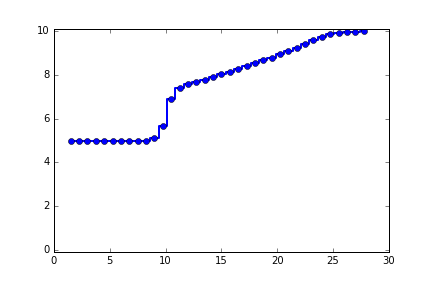
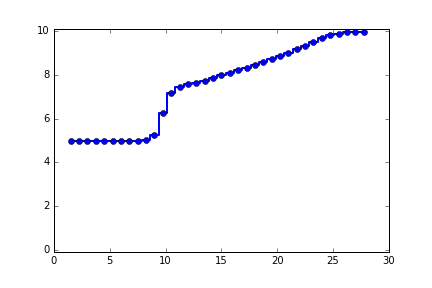
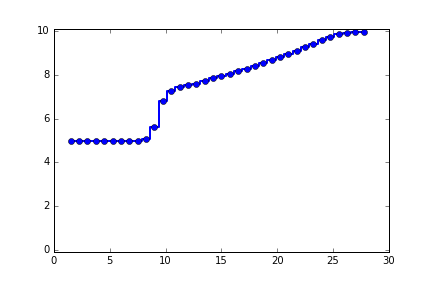
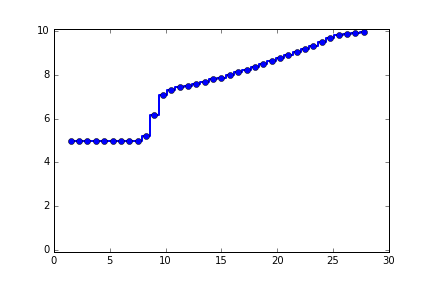
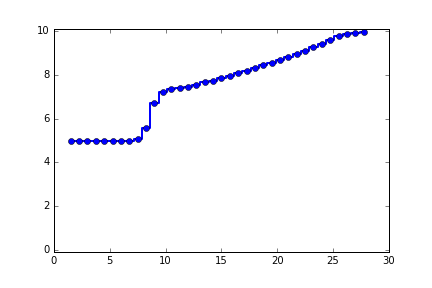
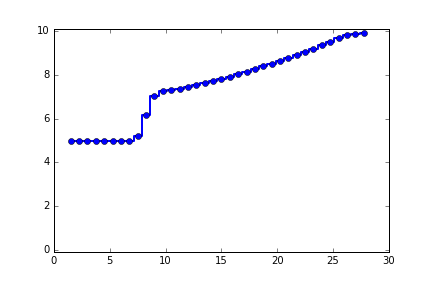
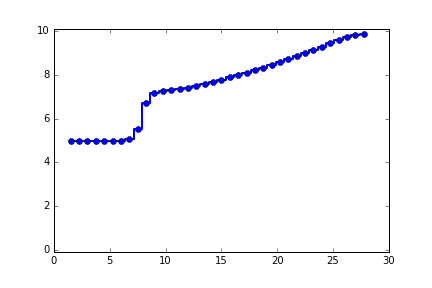
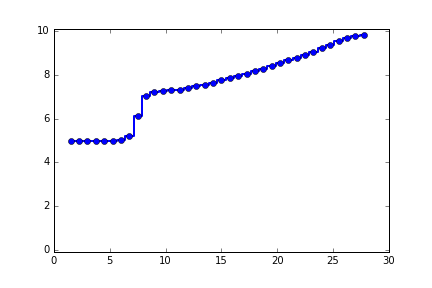
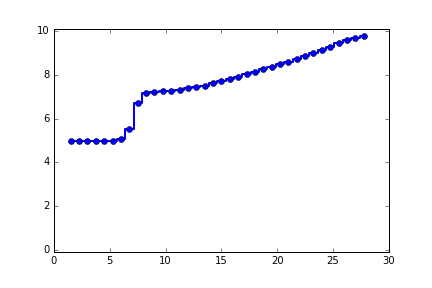
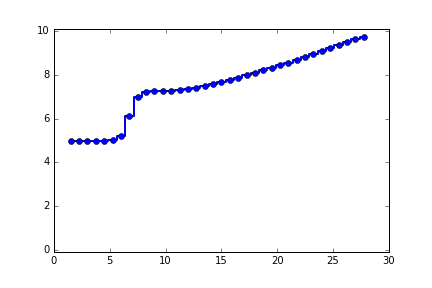
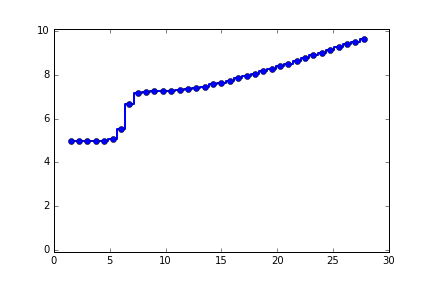
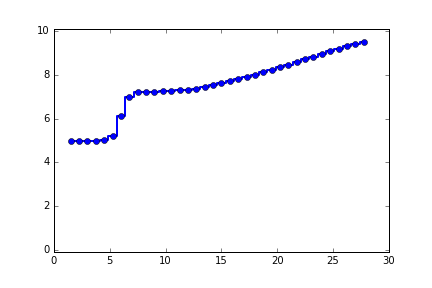
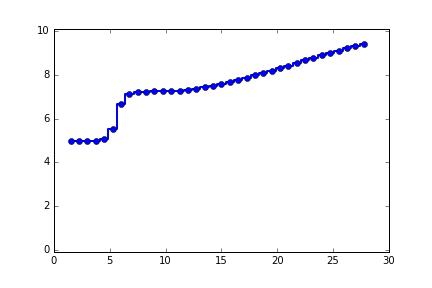
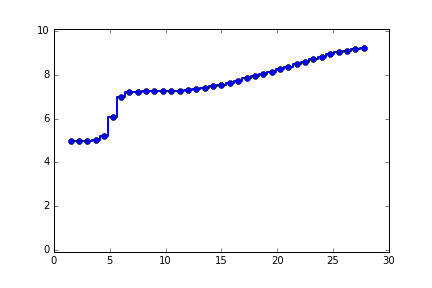
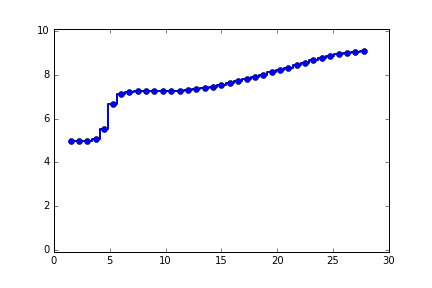
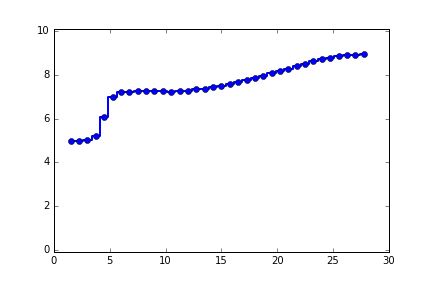
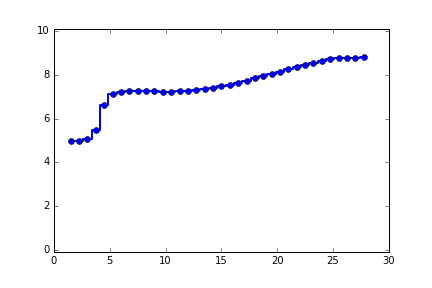
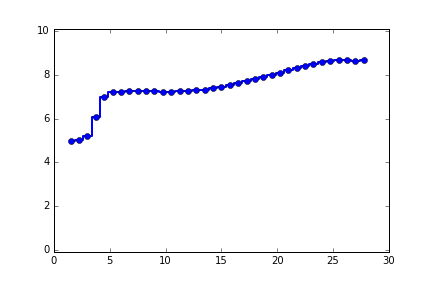
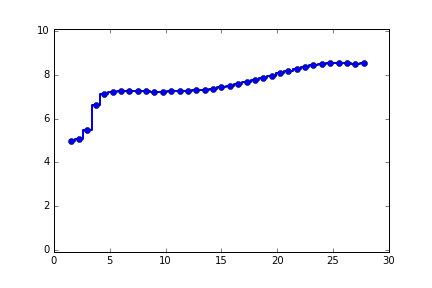
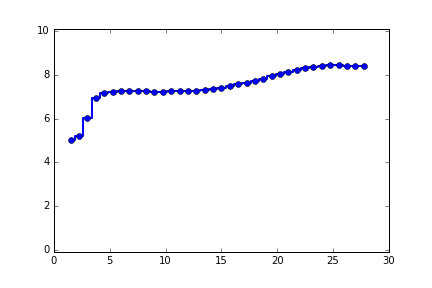
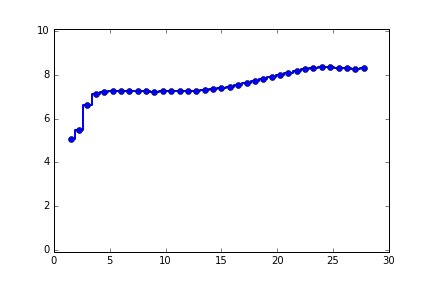
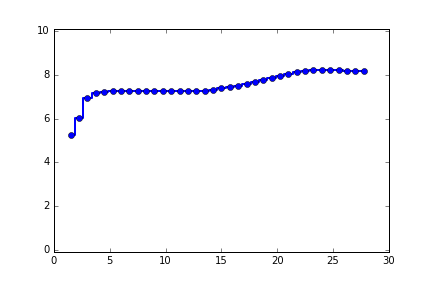
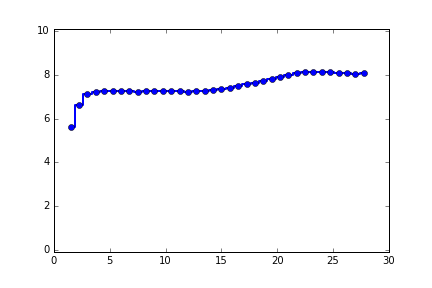
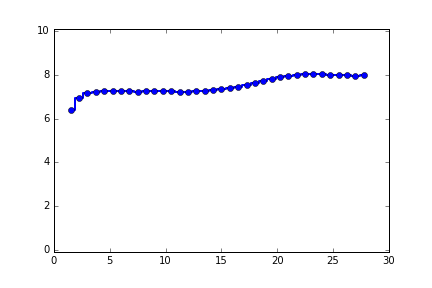
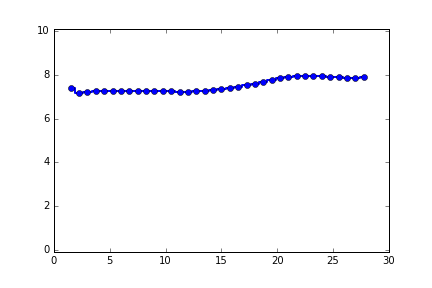
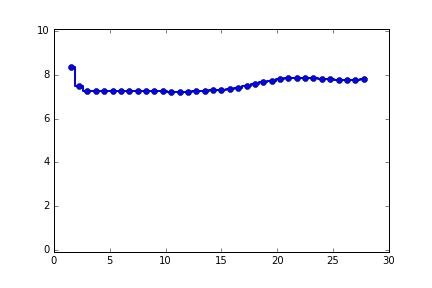
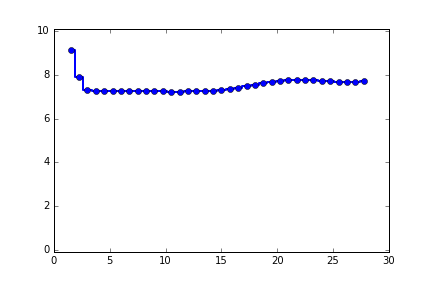
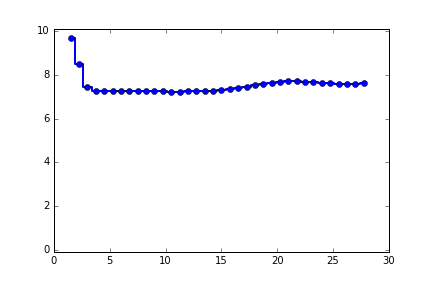
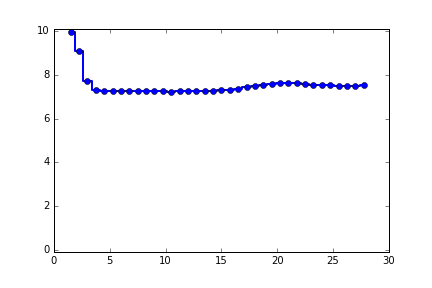
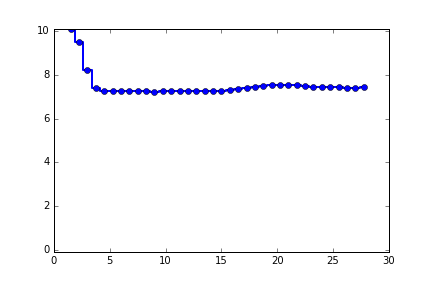
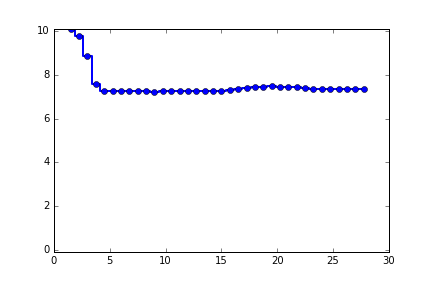
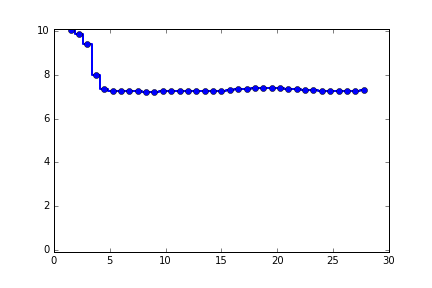
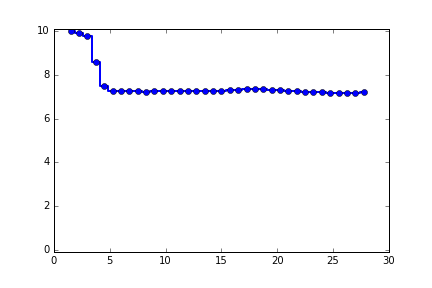
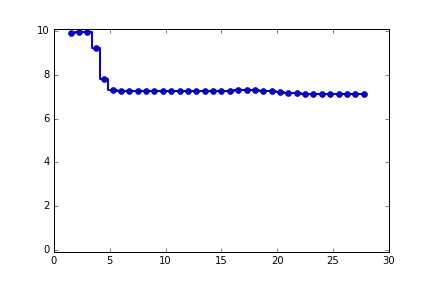
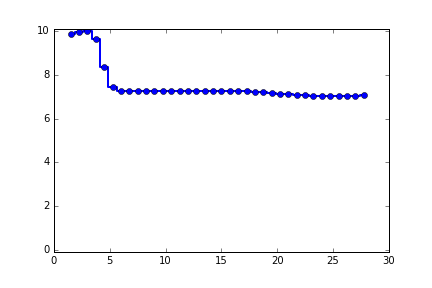
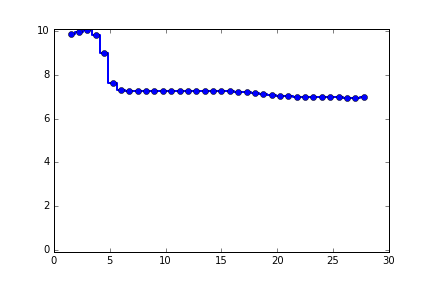
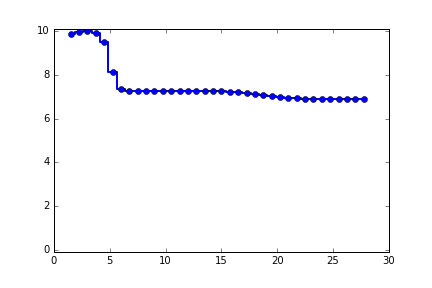
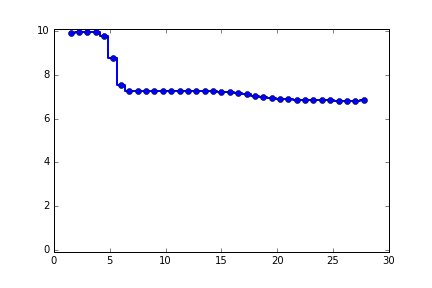
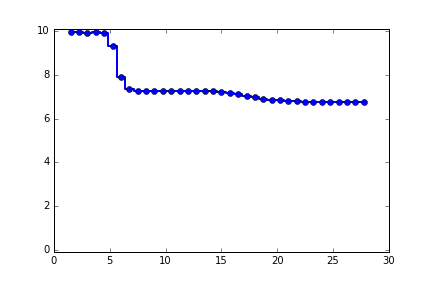
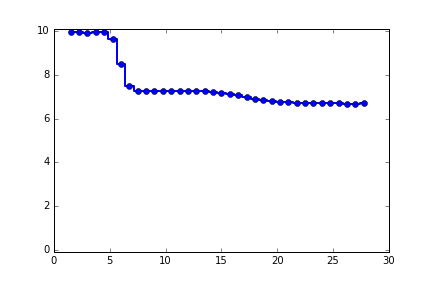
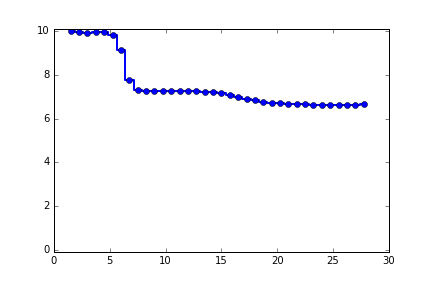
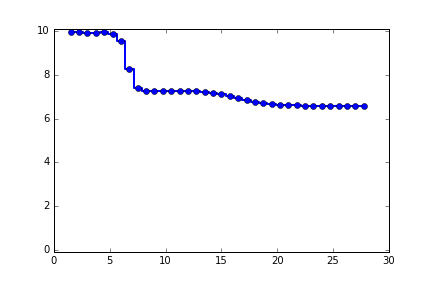
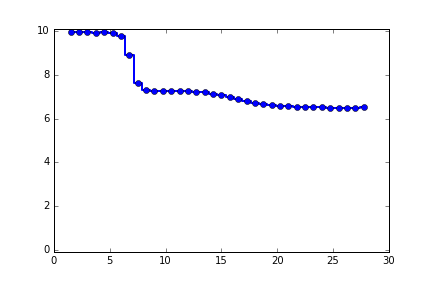
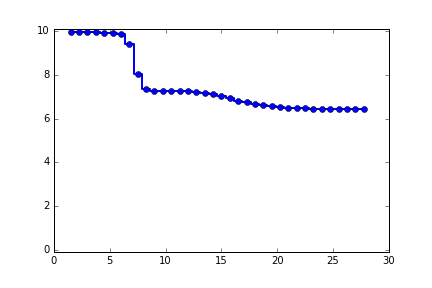
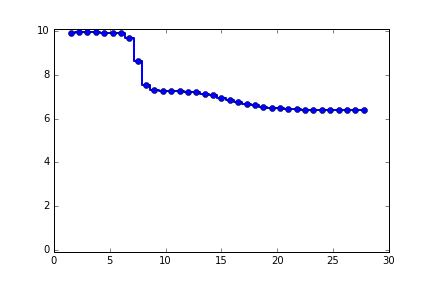
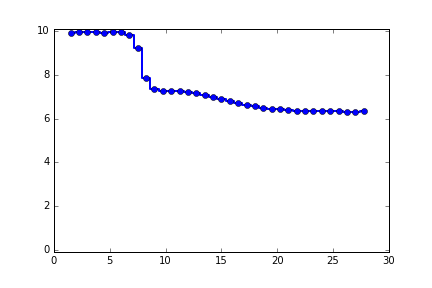
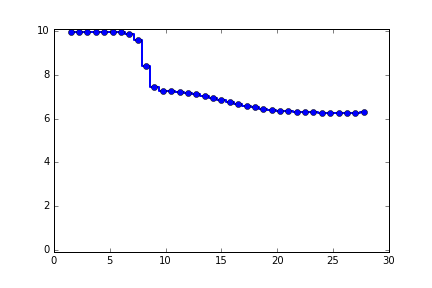
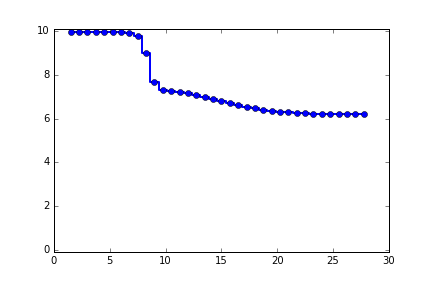
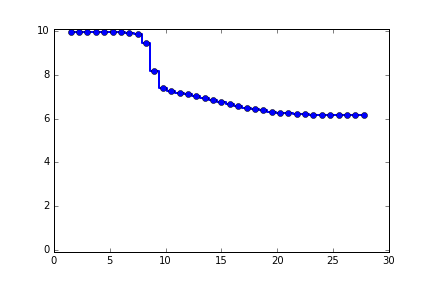
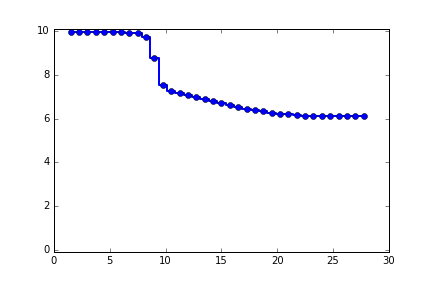
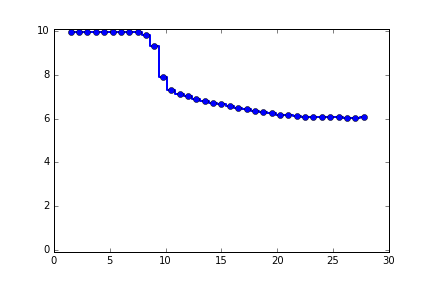
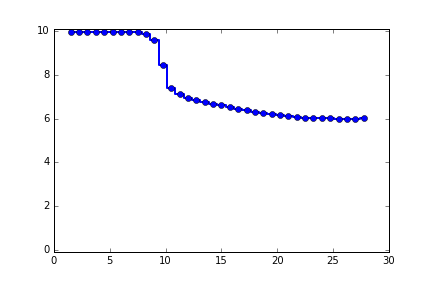
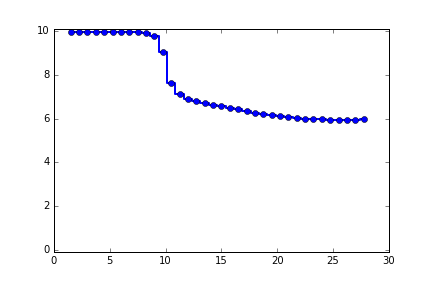
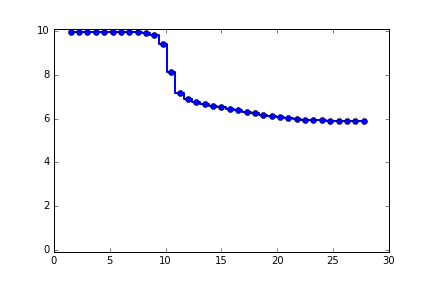
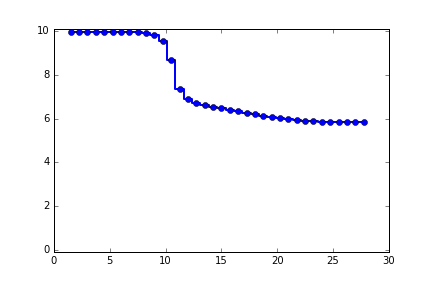
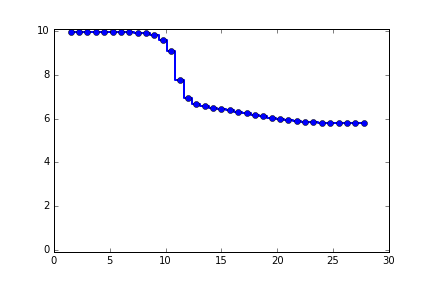
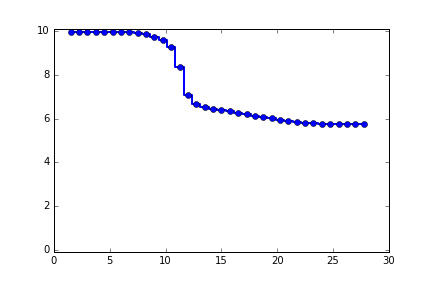
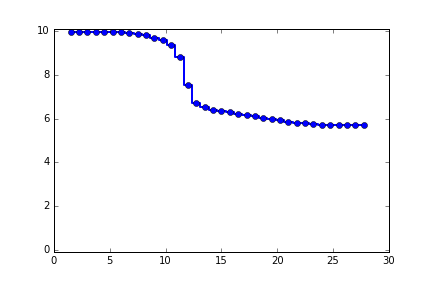
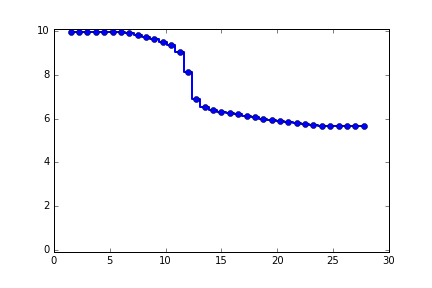

In [33]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 30), ylim=(-0.1, 10.1))
line, = ax.step([], [], 'o-',lw=2,where='mid')
# plt.plot(x,d)
def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x[2:-2], h[i*2,2:-2])
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=nt/2-1, interval=45)

In [34]:
import nswe

In [35]:
nswe.fluxes?

In [36]:
def simulate_order1(h,hu,bcs,dx,cfl,t0,nt):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        h,hu = bcs(h,hu,n)    
        
        f = nswe.fluxes(h[n,:],hu[n,:],nx)

        h[n+1,1:-1] = h[n,1:-1] -dt/dx*(f[0,1:] - f[0,:-1])
        hu[n+1,1:-1] = hu[n,1:-1] -dt/dx*(f[1,1:] - f[1,:-1])
        
    return t,h,hu

In [37]:
nswe.fluxes?

In [38]:
t1,h1,hu1 = simulate_order1(h,hu,bcs_closed,dx,cfl,t0,nt)

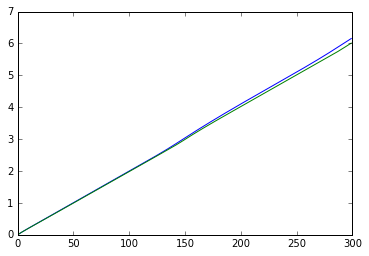

In [39]:
plt.plot(t1)
plt.plot(t)

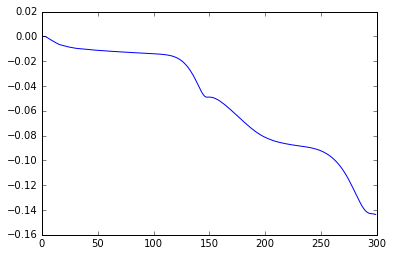

In [40]:
plt.plot(t-t1)


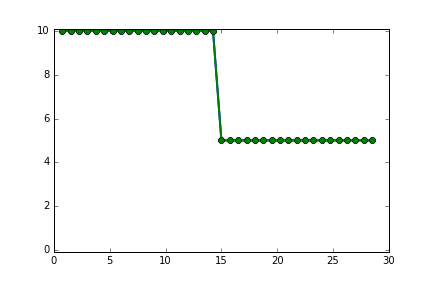
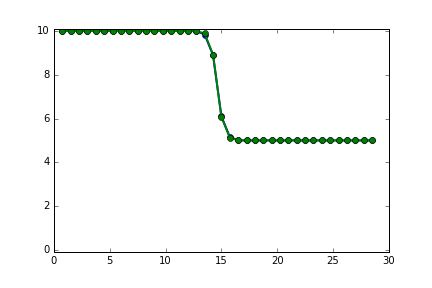
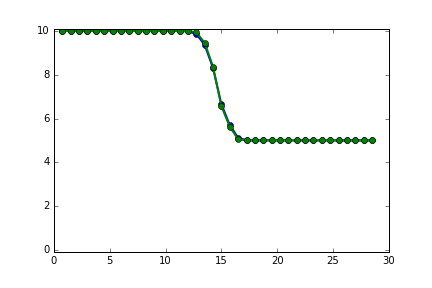
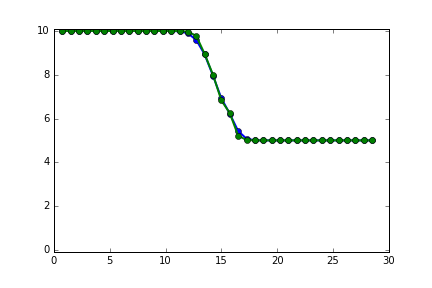
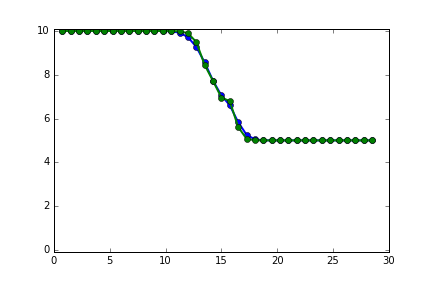
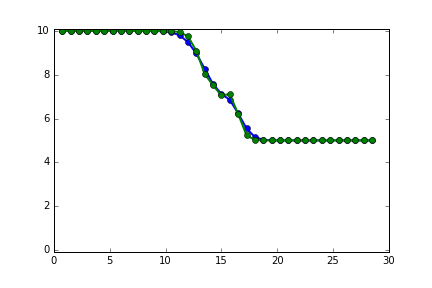
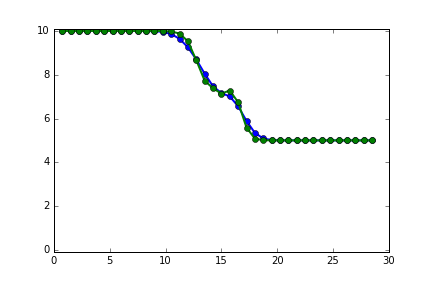
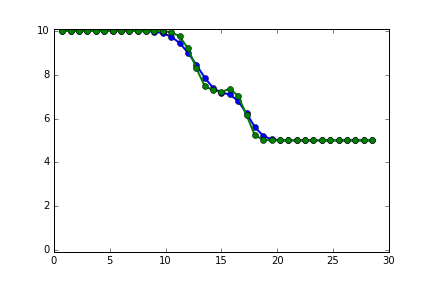
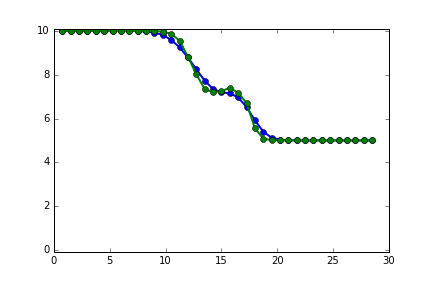
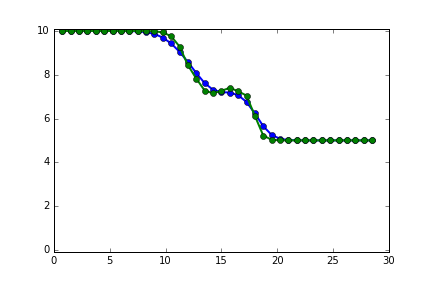
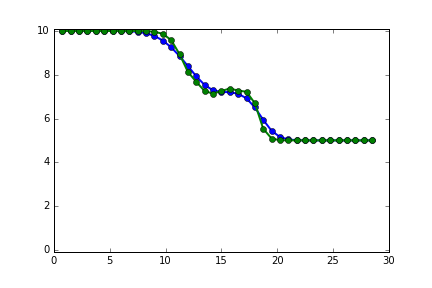
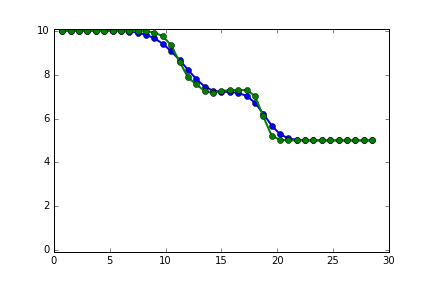
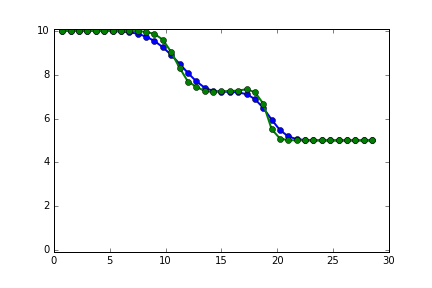
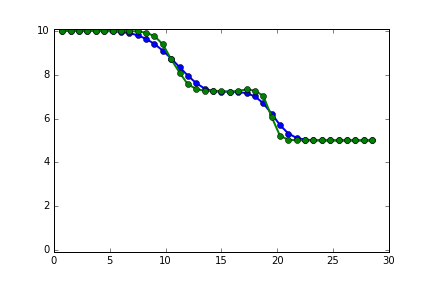
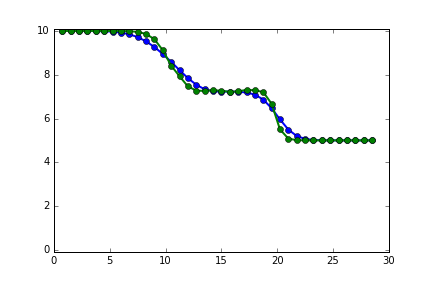
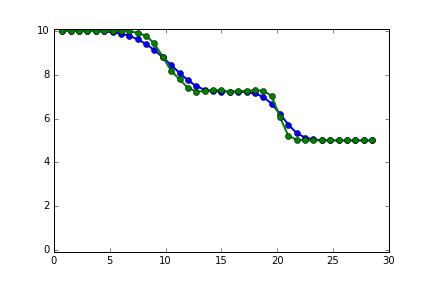
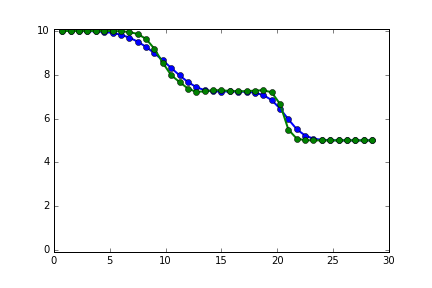
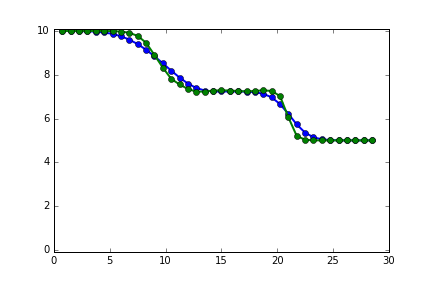
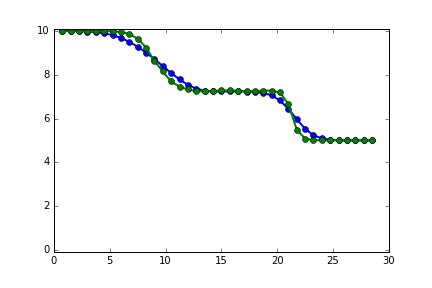
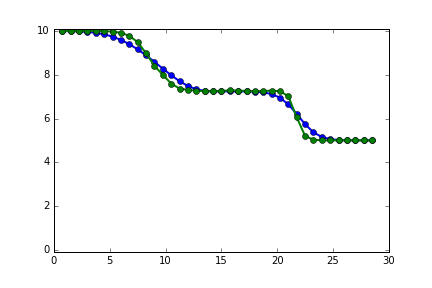
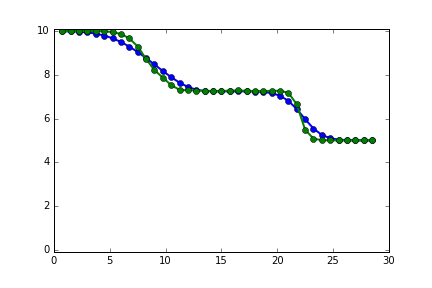
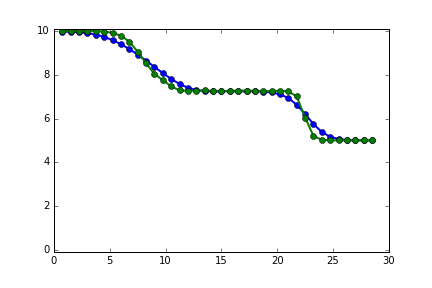
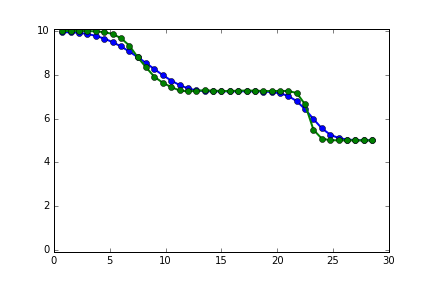
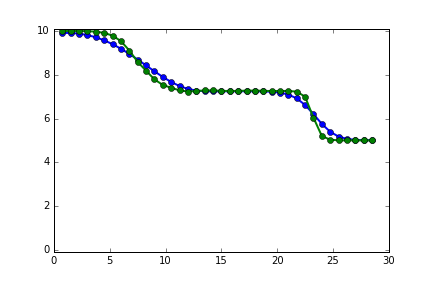
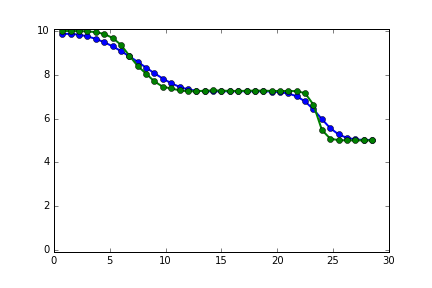
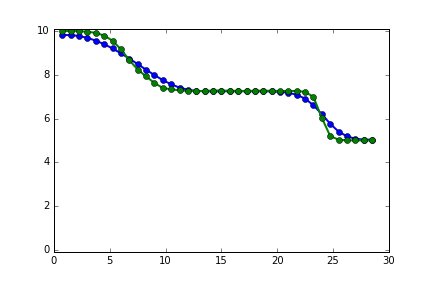
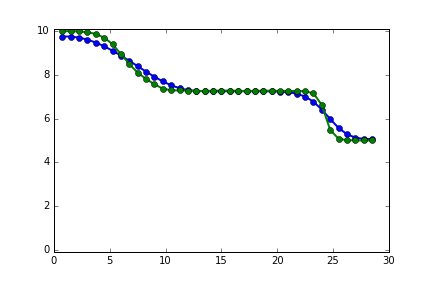
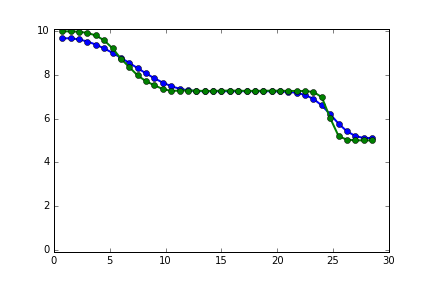
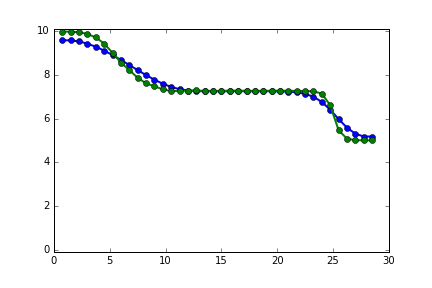
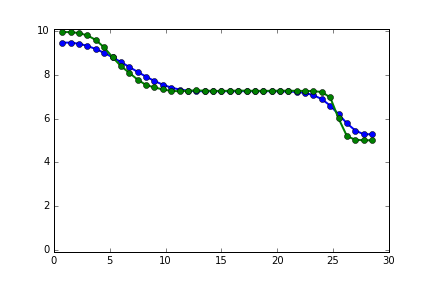
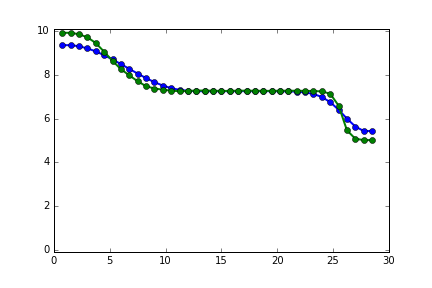
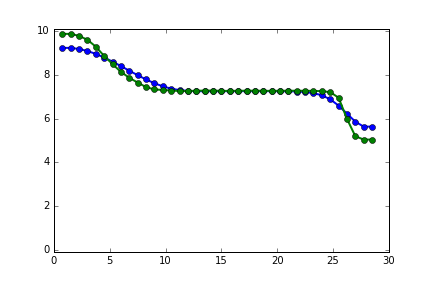
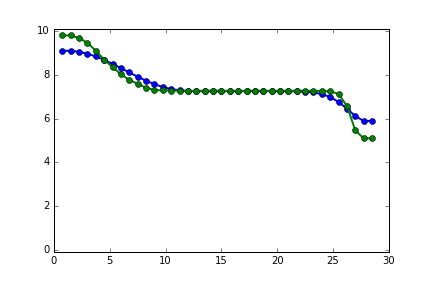
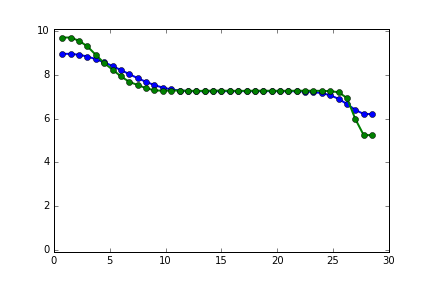
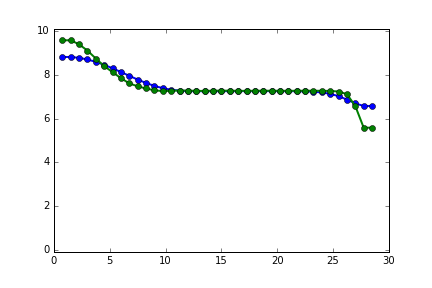
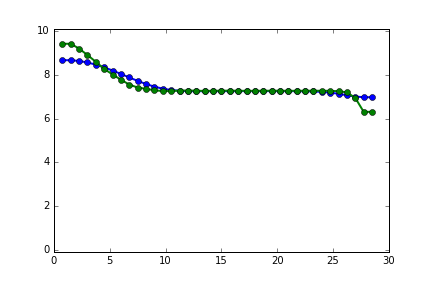
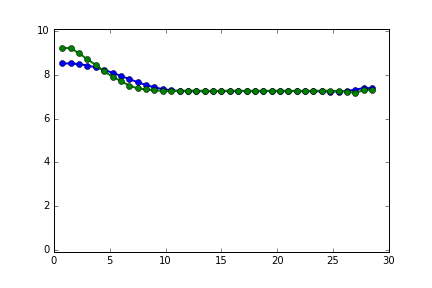
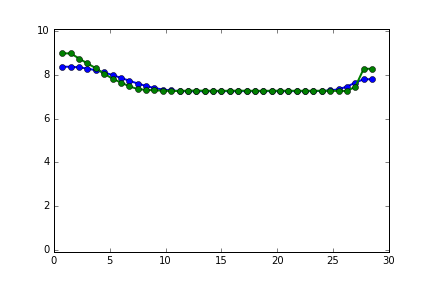
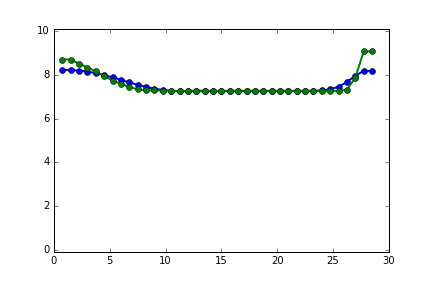
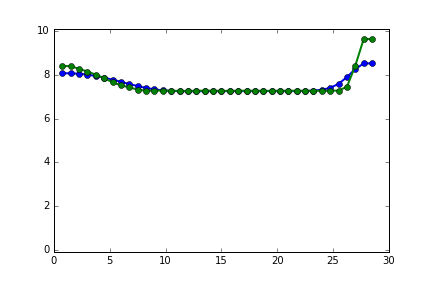
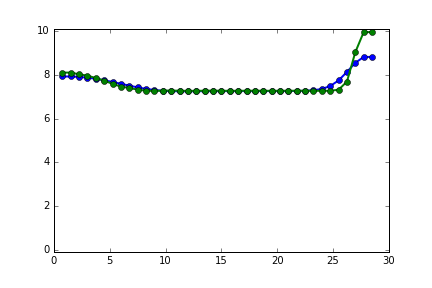
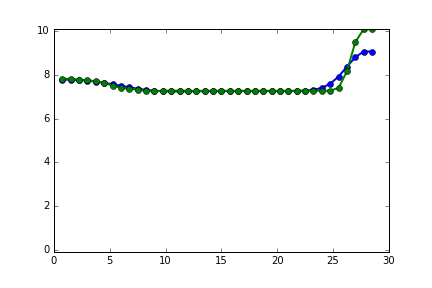
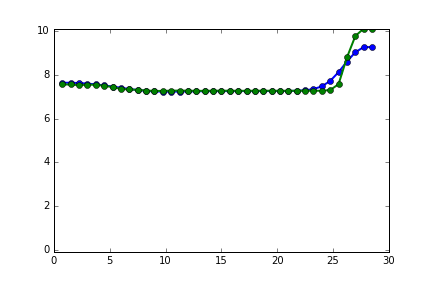
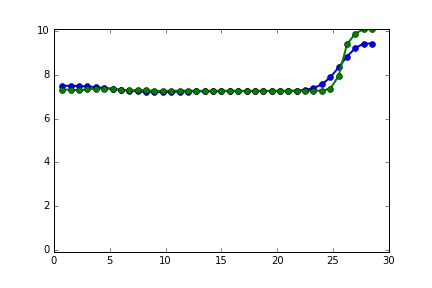
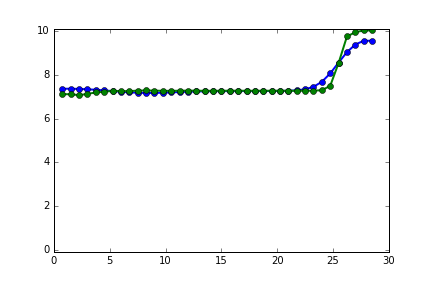
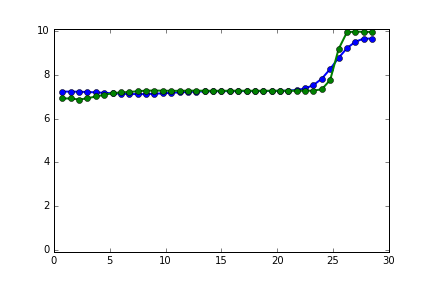
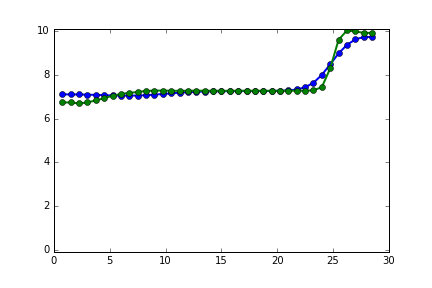
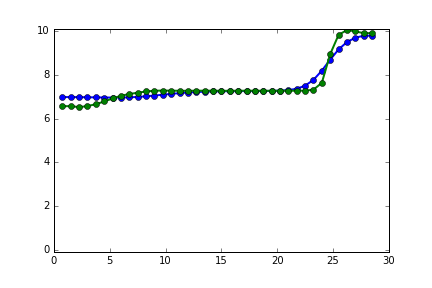
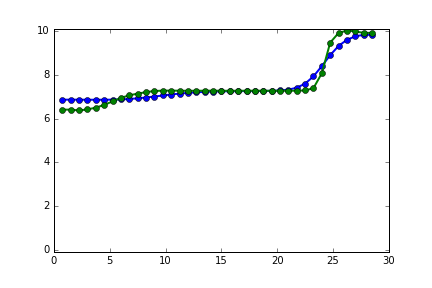
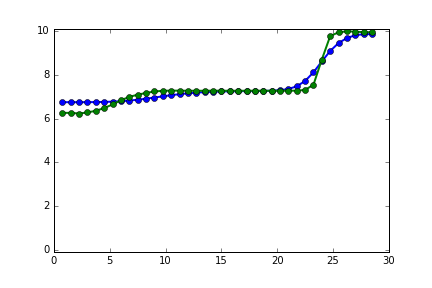
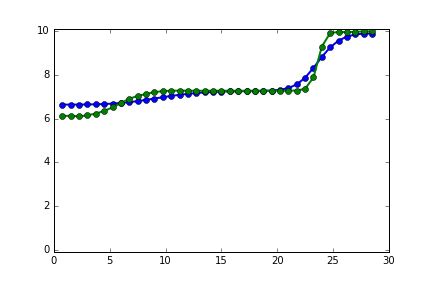
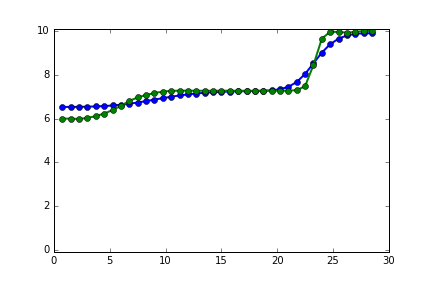
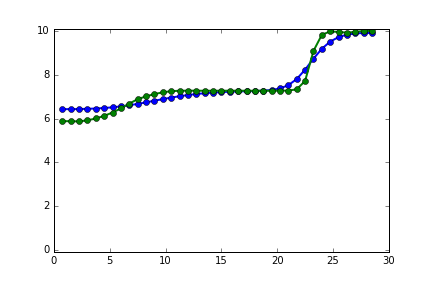
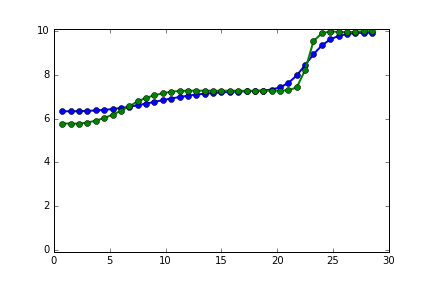
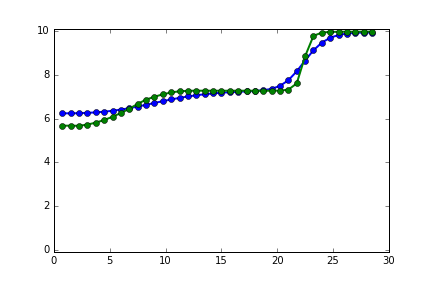
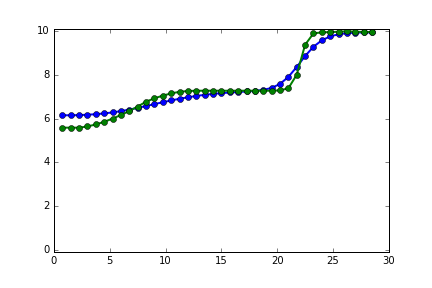
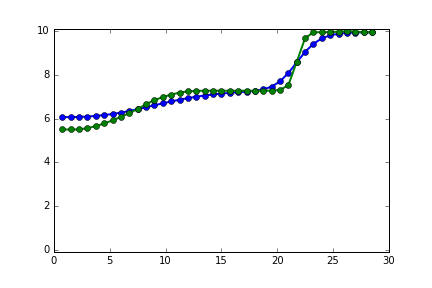
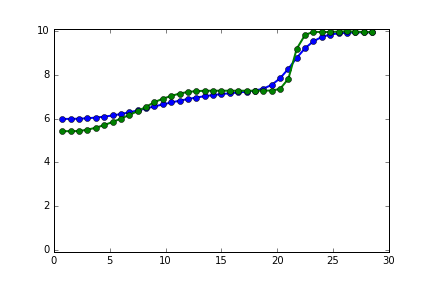
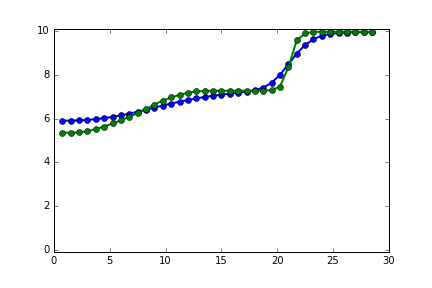
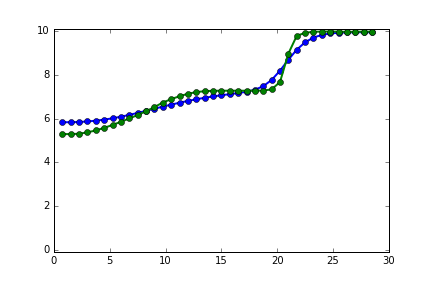
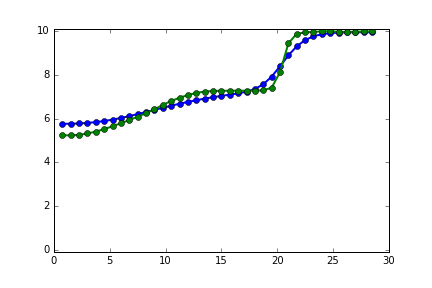
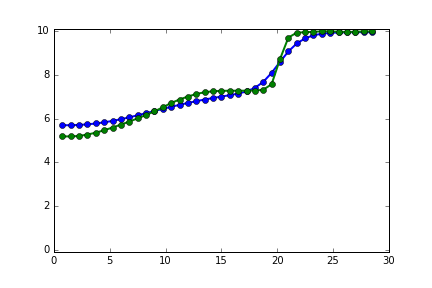
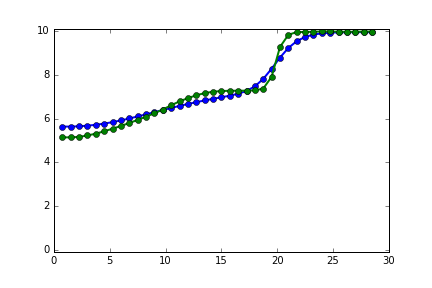
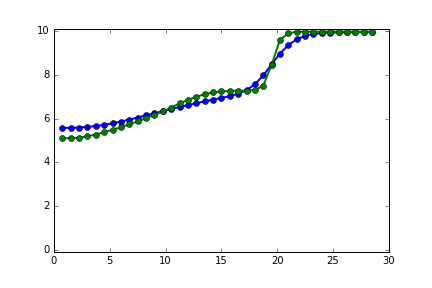
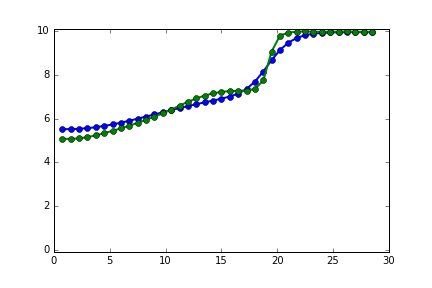
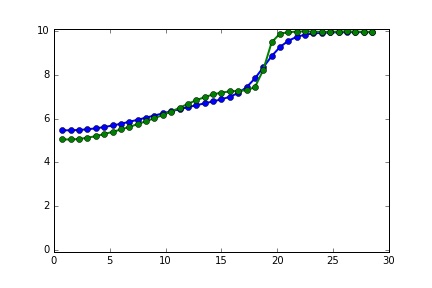
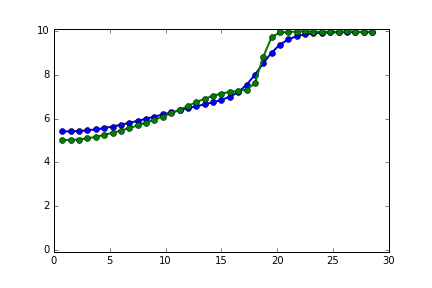
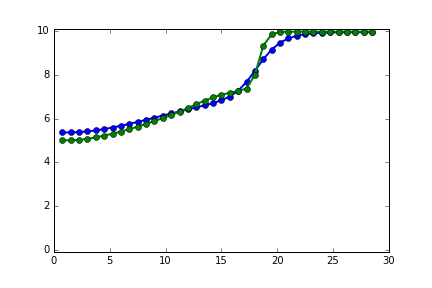
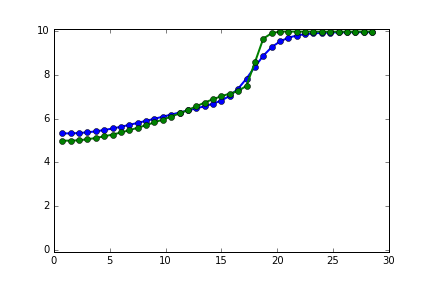
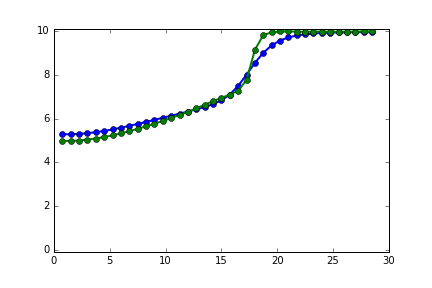
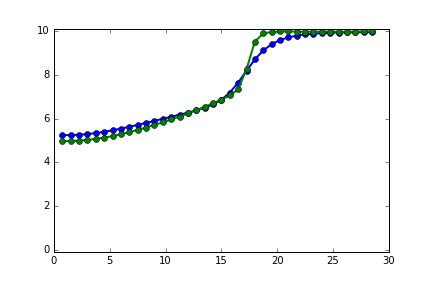
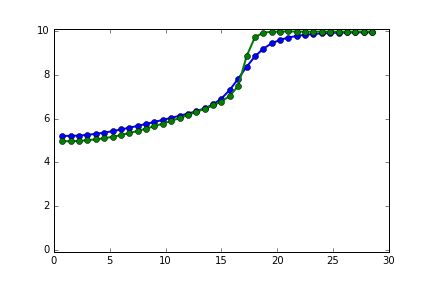
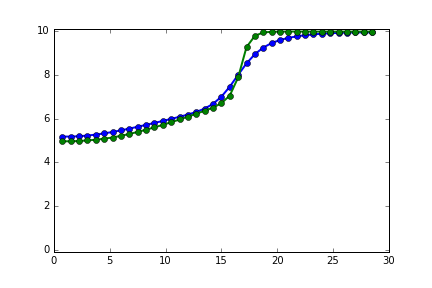
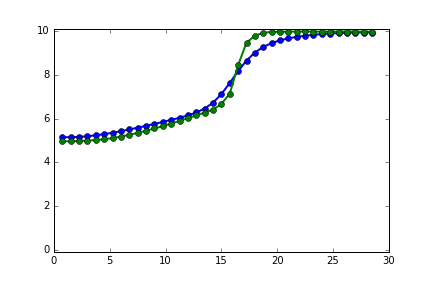
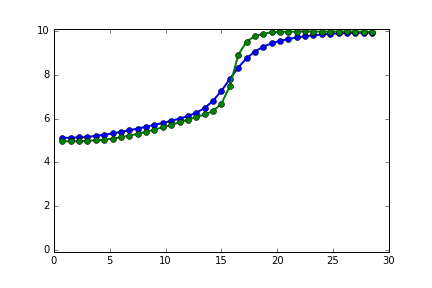
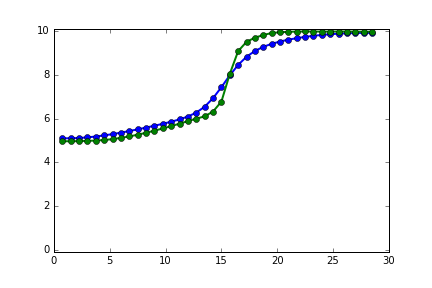
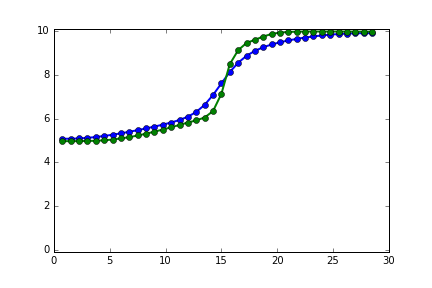
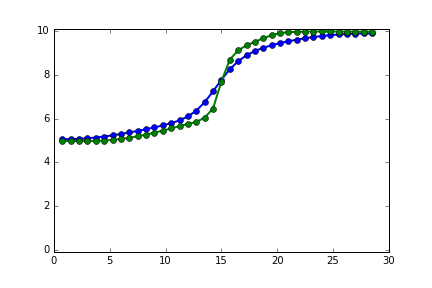
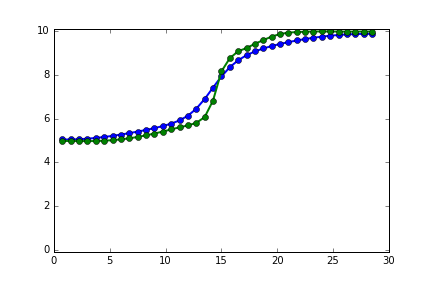
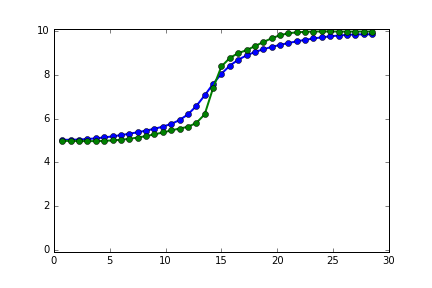
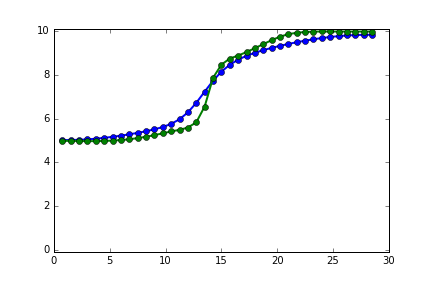
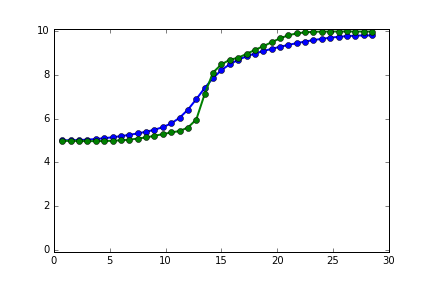
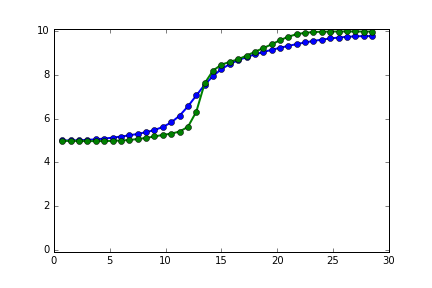
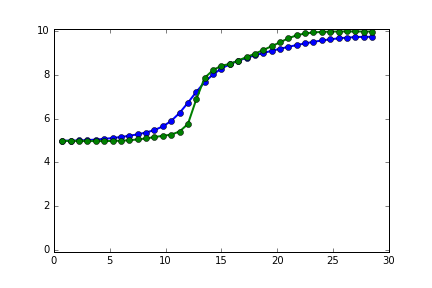
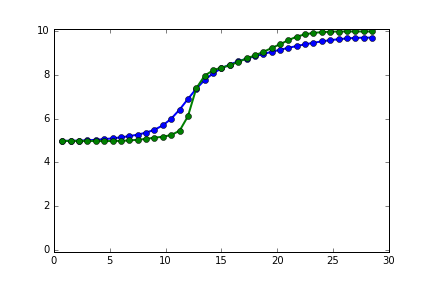
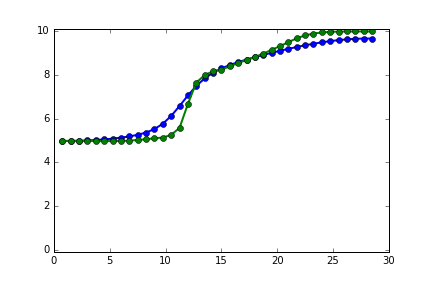
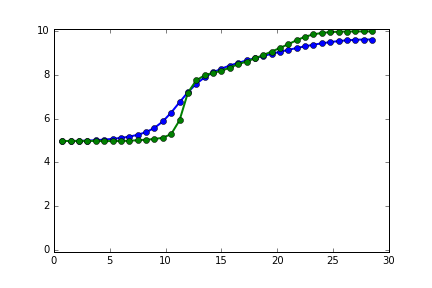
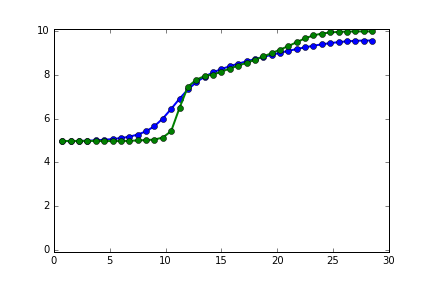
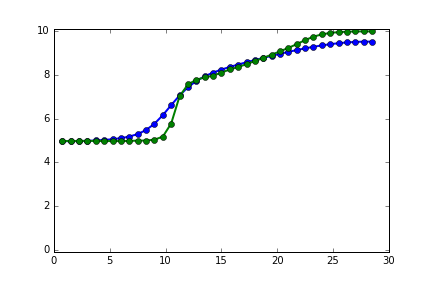
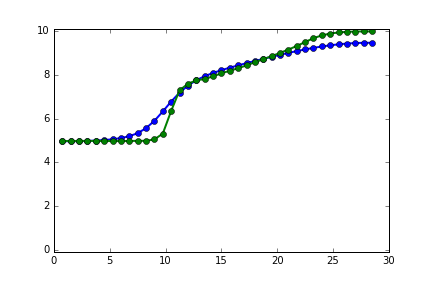
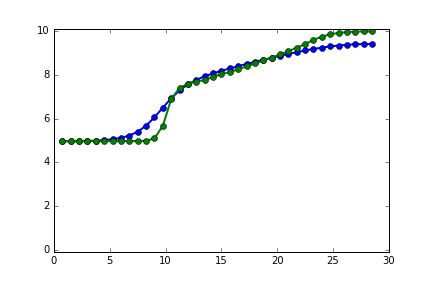
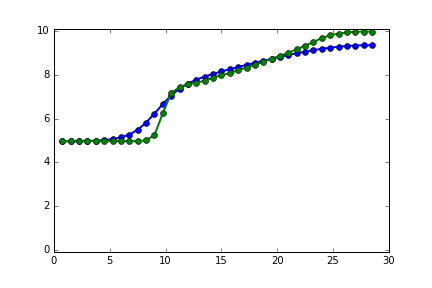
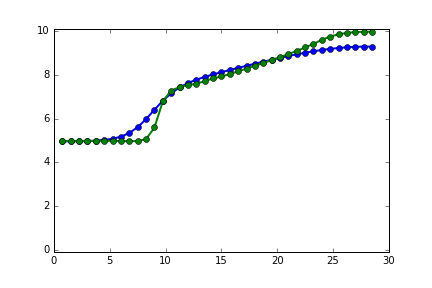
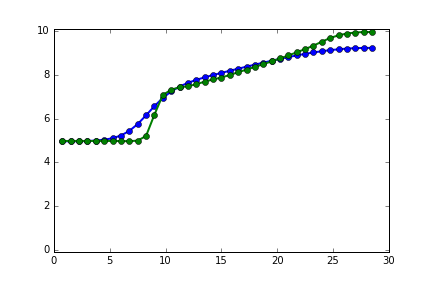
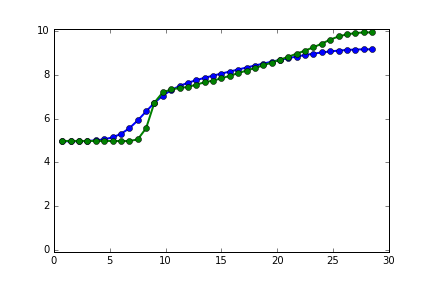
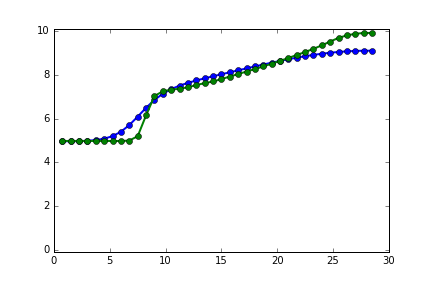
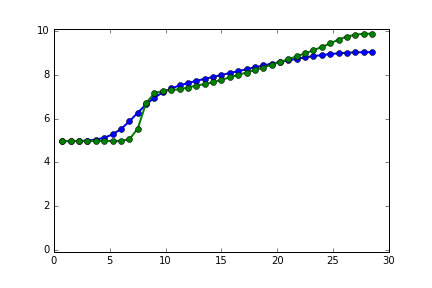
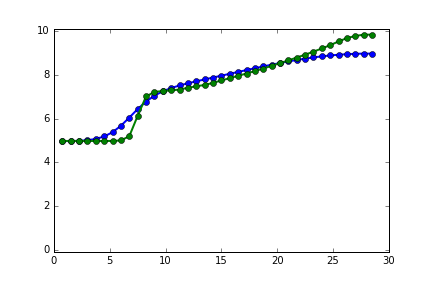
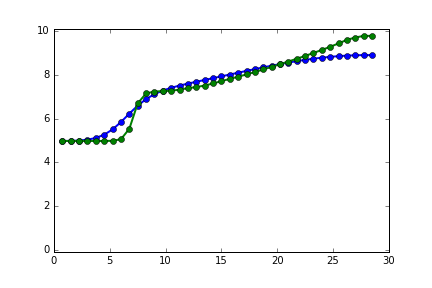
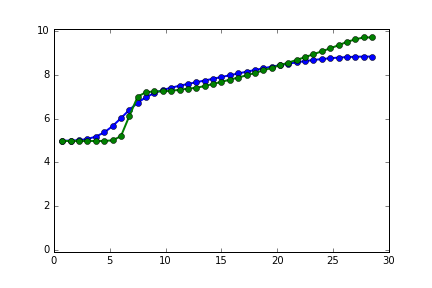
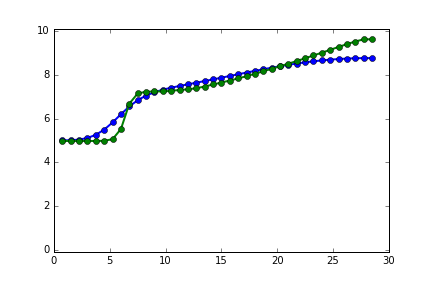
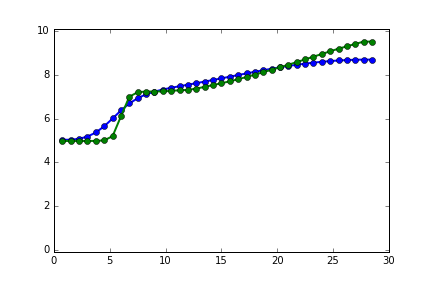
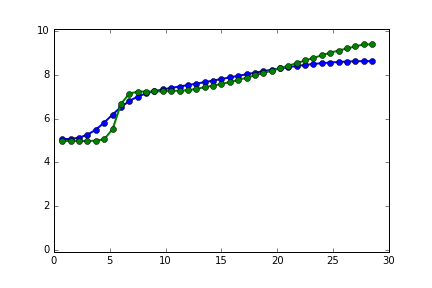
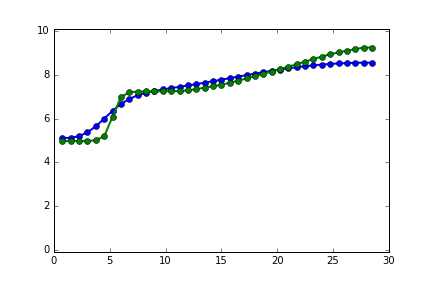
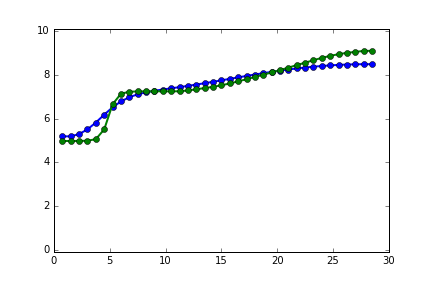
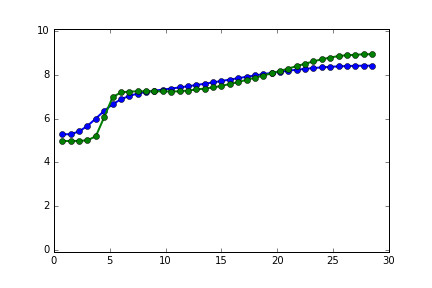
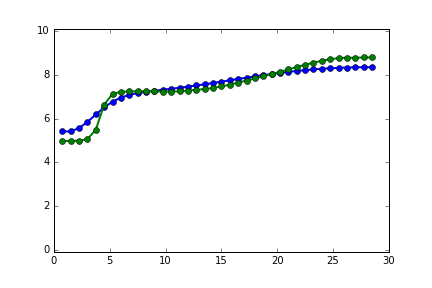
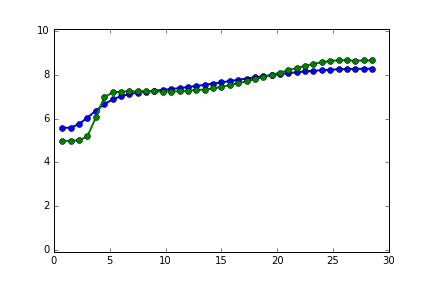
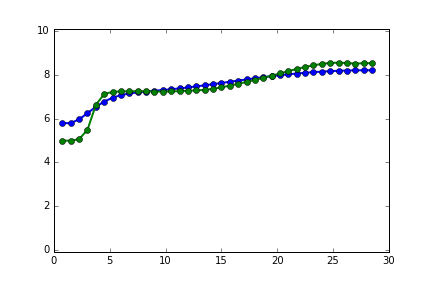
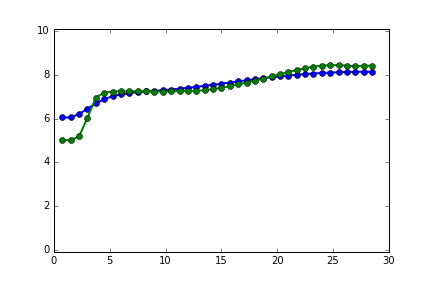
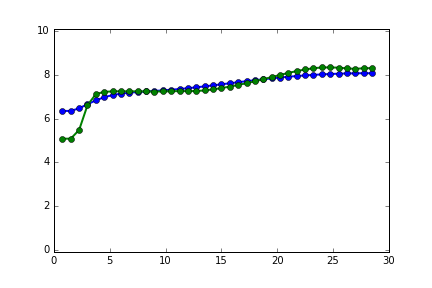
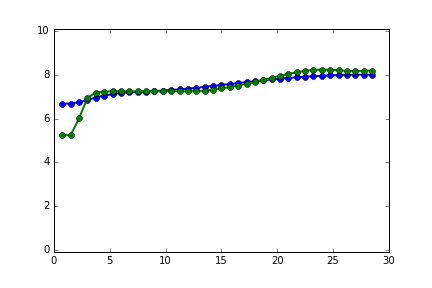
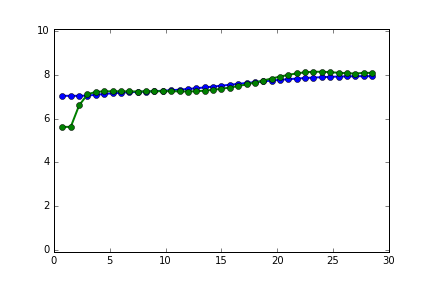
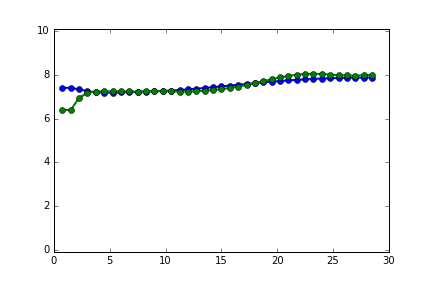
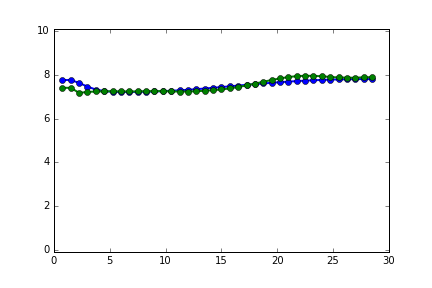
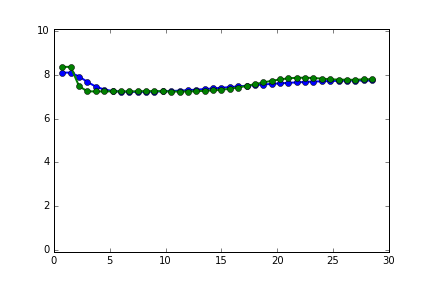
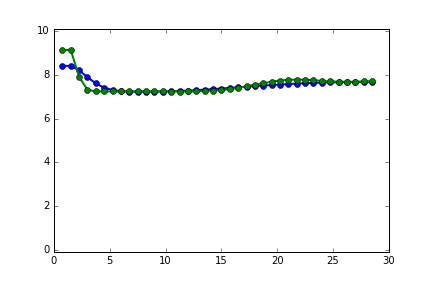
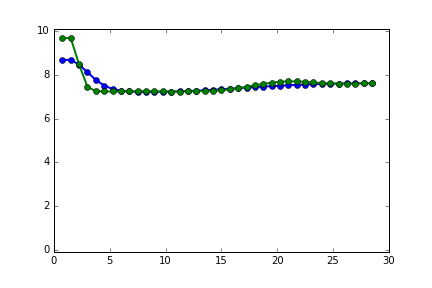
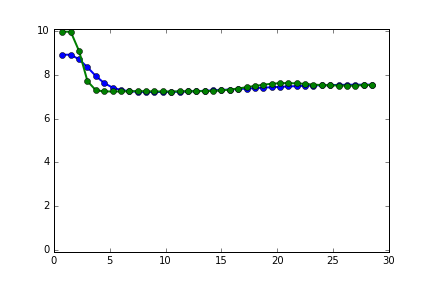
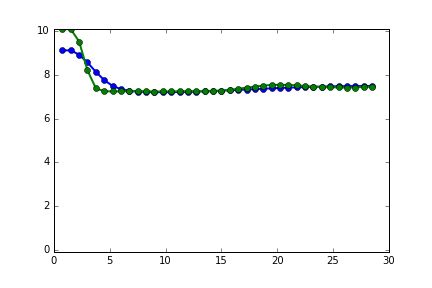
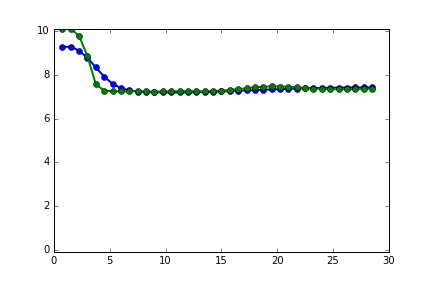
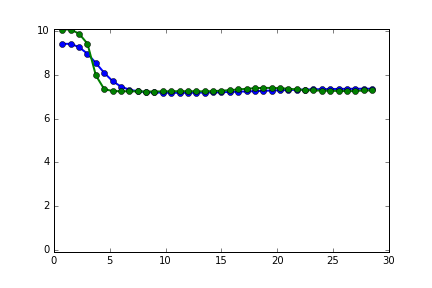
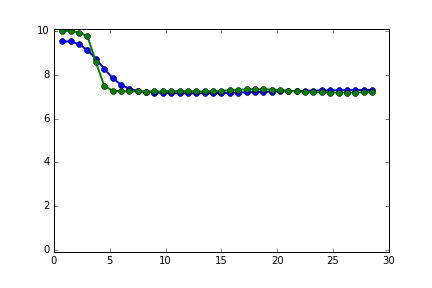
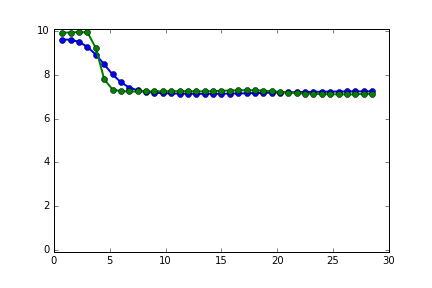
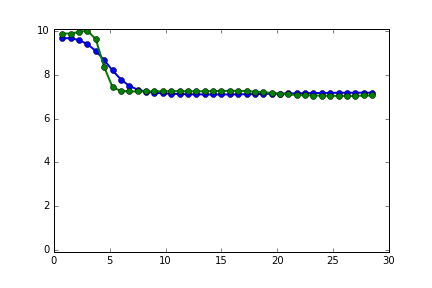
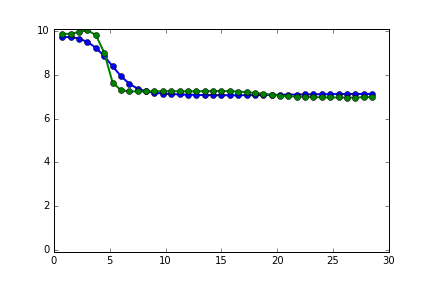
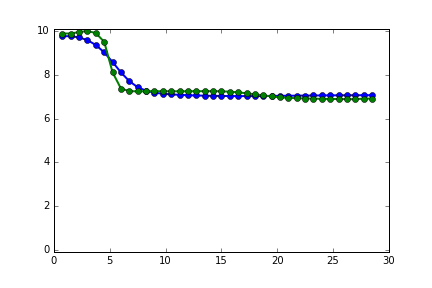
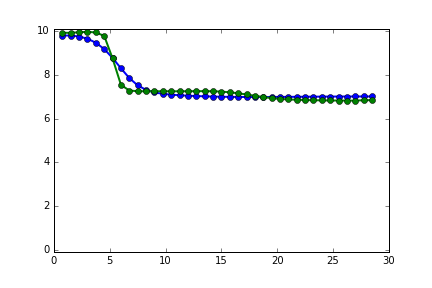
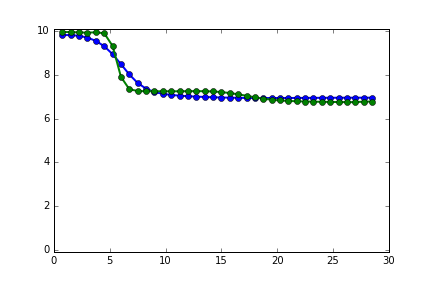
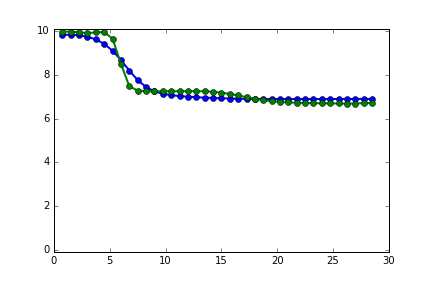
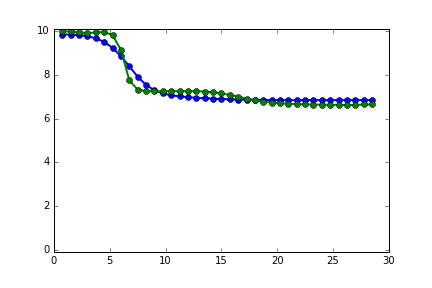
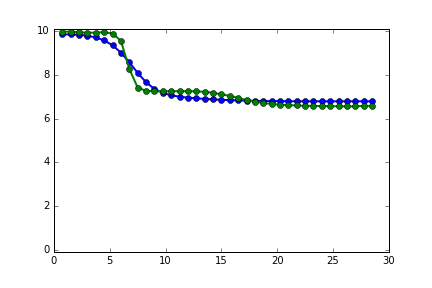
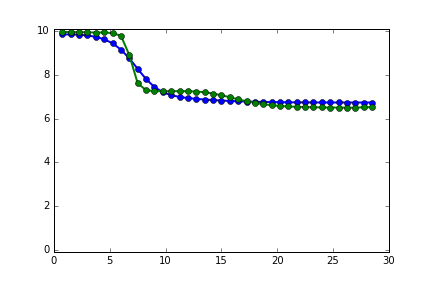
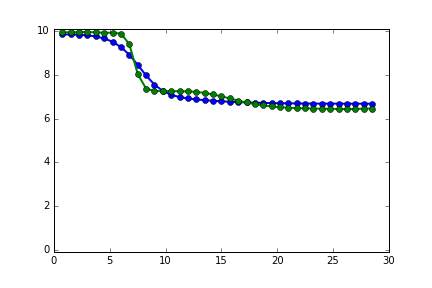
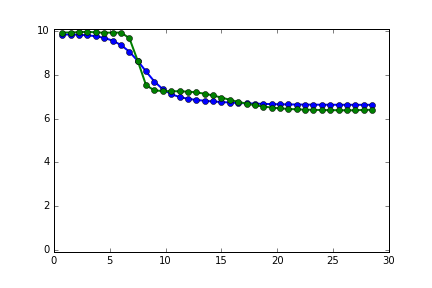
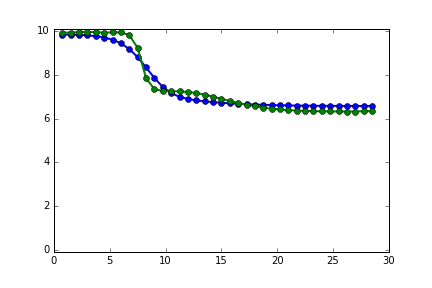
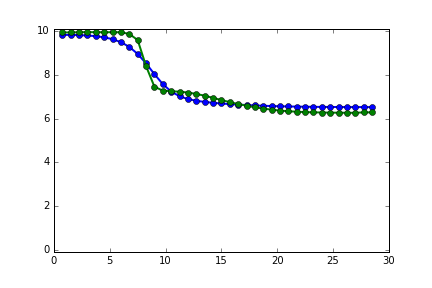
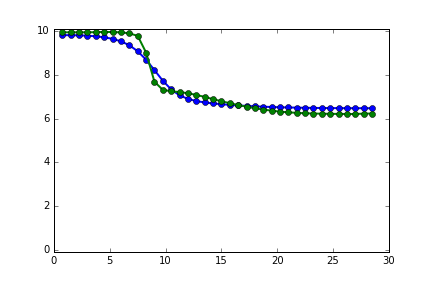
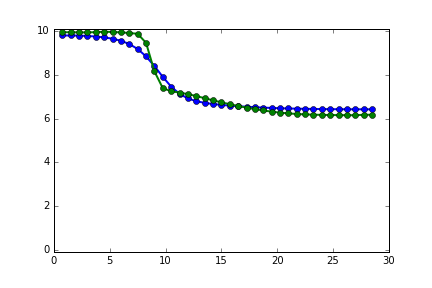
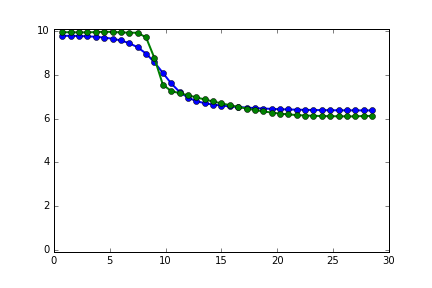
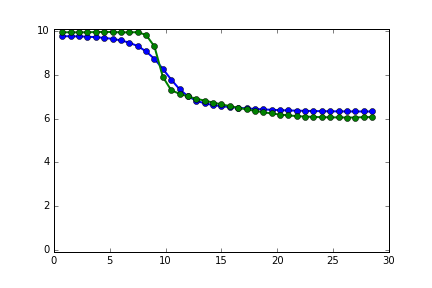
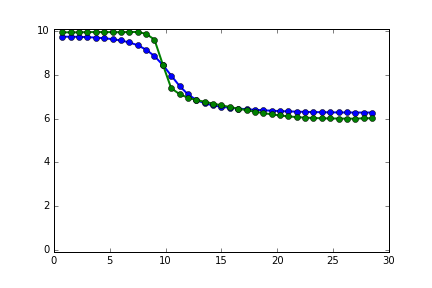
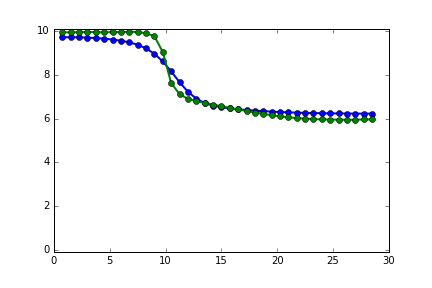
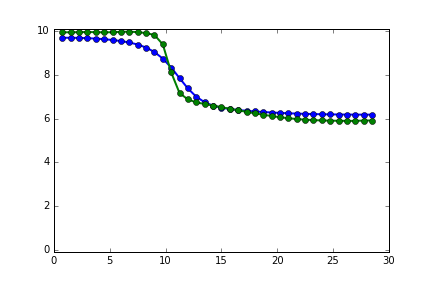
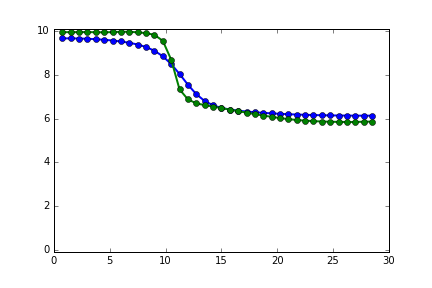
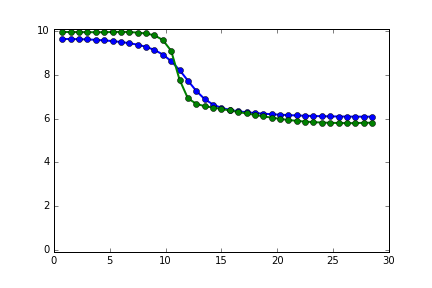
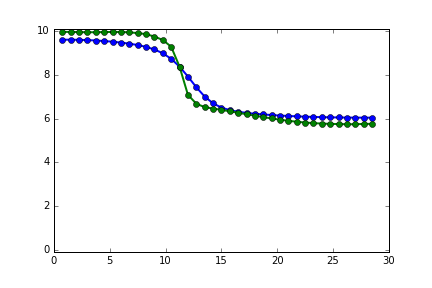
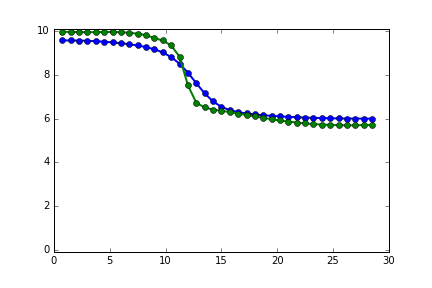
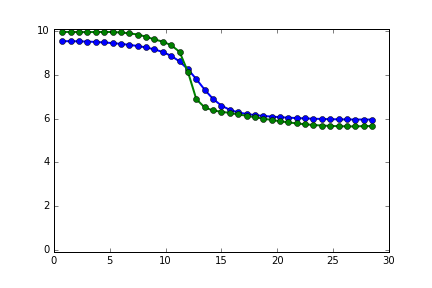

In [41]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 30), ylim=(-0.1, 10.1))
# line1, = ax.step([], [], 'o-',lw=2,where='mid')
# line2, = ax.step([], [], 'o-',lw=2,where='mid')
line1, = ax.plot([], [], 'o-',lw=2)
line2, = ax.plot([], [], 'o-',lw=2)
# plt.plot(x,d)
def init():
    line1.set_data([], [])
    line2.set_data([],[])
    return line1,line2

def animate(i):
    line1.set_data(x[1:-1], h1[i*2,1:-1])
    line2.set_data(x[1:-1], h[i*2,1:-1])
    return line1,line2

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=nt/2-1, interval=45)